#OpenAI Gym for trading on continous intraday energy market
---

Order book is implmented in a discretized fixed price range

Orders are linked lists of (quant, time) data pairs at each price

This allows for generalized order sizes, and keeps track of entry time on
the book.

Book is initialized with orders near one discrete tick off mid price

##Geometric Brownian Motion creation.
As to generate several simulations of the mid price e volatility for the electricity market, we use a GBM to do that.


In [ ]:
import numpy as np

def sn_random_numbers(shape, antithetic=True, moment_matching=True, fixed_seed=False):
  '''
  Returns an array of "shape" with pseudo-random numbers that are standard normally distributed

  Parameters
    ==========
    shape : tuple (o, n, m)
        generation of array with shape (o, n, m)
    antithetic : Boolean
        generation of antithetic variates
    moment_matching : Boolean
        matching of first and second moments
    fixed_seed : Boolean
        flag to fix the seed

    Results
    =======
    ran : (o, n, m) array of (pseudo)random numbers
  '''
  if fixed_seed:
    np.random.seed(42)
  if antithetic:
    ran = np.random.standard_normal((shape[0], shape[1], int(shape[2] / 2)))
    ran = np.concatenate((ran, -ran), axis=2)
  else:
    ran = np.random.standard_normal(shape)
  if moment_matching:
    ran = ran - np.mean(ran)
    ran = ran / np.std(ran)
  if shape[0] == 1:
    return ran[0]
  else:
    return ran


In [ ]:
ran_ary = sn_random_numbers((2,2,2), True, True, True)
print(ran_ary)

[[[ 0.57308232 -0.57308232]
  [-0.15952198  0.15952198]]

 [[ 0.74726852 -0.74726852]
  [ 1.7571907  -1.7571907 ]]]


The function below is used to understand the difference between each date in terms of year's fraction

In [ ]:
from datetime import datetime, timedelta
import random

def get_year_deltas(date_list, day_count=365.):
  '''
  Return vector of floats with day deltas in years.
  Initial value normalized to zero.

  Parameters
  ==========
  date_list : list or array
      collection of datetime objects
  day_count : float
      number of days for a year
      (to account for different conventions)

  Results
  =======
  delta_list : array
      year fractions
  '''
  start = date_list[0]
  delta_list = [(date - start).days / day_count for date in date_list]
  return np.array(delta_list)

In [ ]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 1, 1)

date_collection = []

for i in range(5):
    random_date = start_date + (end_date - start_date) * random.random()
    date_collection.append(random_date)

# print("Date collection")
# print(date_collection)
yDel = get_year_deltas(date_collection,365.)
print(yDel)

[ 0.         -0.20821918  0.16712329  0.00821918 -0.29041096]


### Now we define the *Costant Short Rate* class.

The constant short rate is a simple model for risk-neutral discounting that assumes a constant interest rate over time. It is represented by a decimal value that specifies the continuously compounded annualized interest rate at which an entity can borrow money for an infinitesimally short period of time.

The constant short rate is used in finance as part of short rate models, which are mathematical models that illustrate the evolution of interest rates over time. These models are used to price interest rate derivatives by identifying the evolution of the short rate over time

In [ ]:

class constant_short_rate(object):
  '''
  Class for constant short rate discounting.

  Attributes
  ==========
  name : string
      name of the object
  short_rate : float (positive)
      constant rate for discounting

  Methods
  =======
  get_discount_factors :
      get discount factors given a list/array of datetime objects
      or year fractions
  '''
  def __init__(self, name, short_rate):
    self.name = name
    self.short_rate = short_rate
    if short_rate < 0:
      raise ValueError('Short rate negative')

  def get_discount_factors(self, date_list, dtobjects=True):
    if dtobjects is True:
      dList = get_year_deltas(date_list)
    else:
      dList = np.array(date_list)
    dfList = np.exp(self.short_rate * np.sort(-dList))
    # print(np.array((date_list, dfList)).T)
    return np.array((date_list, dfList)).T

In [ ]:
csr1 = constant_short_rate("cos_short_rate_1", 2)
csr1.get_discount_factors(date_collection, True)

array([[datetime.datetime(2022, 7, 21, 0, 56, 3, 626906),
        0.7158772427866629],
       [datetime.datetime(2022, 5, 6, 5, 9, 27, 201355),
        0.9836960163172332],
       [datetime.datetime(2022, 9, 20, 21, 0, 24, 401087), 1.0],
       [datetime.datetime(2022, 7, 24, 21, 15, 54, 842114),
        1.5165505124503524],
       [datetime.datetime(2022, 4, 6, 2, 18, 9, 108374),
        1.7875070109859201]], dtype=object)

In [ ]:
class market_environment(object):
  '''
  Class to model a market environment relevant for valuation.

  Attributes
  ==========
  name: string
      name of the market environment
  pricing_date : datetime object
      date of the market environment

  Methods
  =======
  add_constant :
      adds a constant (e.g. model parameter)
  get_constant :
      gets a constant
  add_list :
      adds a list (e.g. underlyings)
  get_list :
      gets a list
  add_curve :
      adds a market curve (e.g. yield curve)
  get_curve :
      gets a market curve
  add_environment :
      adds and overwrites whole market environments
      with constants, lists, and curves
  '''
  def __init__(self, name, pricing_date):
    self.name = name
    self.pricing_date = pricing_date
    self.constants = {}
    self.lists = {}
    self.curves = {}

  def add_constant(self, key, constant):
    self.constants[key] = constant

  def get_constant(self, key):
    return self.constants[key]

  def add_list(self, key, list_object):
    self.lists[key] = list_object

  def get_list(self, key):
    return self.lists[key]

  def add_curve(self, key, curve):
    self.curves[key] = curve

  def get_curve(self, key):
    return self.curves[key]

  def add_environment(self, env):
    # overwrites existing values, if they exist
    for key in env.constants:
      self.constants[key] = env.constants[key]
    for key in env.lists:
      self.lists[key] = env.lists[key]
    for key in env.curves:
      self.curves[key] = env.curves[key]

In [ ]:
me1 = market_environment("market1", datetime(2022, 6, 13, 4, 47, 26, 165449))

In [ ]:
import pandas as pd

class simulation_class(object):

  '''
  Providing base methods for simulation classes.
  Attributes
  ==========
  name : string
      name of the object
  mar_env : instance of market_environment
      market environment data for simulation
  corr : Boolean
      True if correlated with other model object
  Methods
  =======
  generate_time_grid :
      returns time grid for simulation
  get_instrument_values :
      returns the current instrument values (array)
  '''
  def __init__(self, name, mar_env, corr):
    try:
      self.name = name
      self.pricing_date = mar_env.pricing_date
      self.initial_value = mar_env.get_constant('initial_value')
      self.volatility = mar_env.get_constant('volatility')
      self.final_date = mar_env.get_constant('final_date')
      self.currency = mar_env.get_constant('currency')
      self.frequency = mar_env.get_constant('frequency')
      self.paths = mar_env.get_constant('paths')
      self.discount_curve = mar_env.get_curve('discount_curve')
      try:
        self.time_grid = mar_env.get_list('time_gird')
      except:
        self.time_grid = None

      try:
        self.special_dates = mar_env.get_list('special_dates')
      except:
        self.special_dates = []

      self.instrument_values = None
      self.correlated = corr

      if corr is True:
        # only needed in portfolio context when risk factors are correlated
        self.cholesky_matrix = mar_env.get_list('cholesky_matrix')
        self.rn_set = mar_env.get_list('rn_set')[self.name]
        self.random_numbers = mar_env.get_list('random_numbers')

    except:
      print("Error parsing market environment")

  def generate_time_grid(self):
    start = self.pricing_date
    end = self.final_date

    # Now we use pandas date_range function, freq = e.g. 'B' Businness day, 'W' for Weekly, 'M' for Monthly
    time_grid = pd.date_range(start=start, end=end, freq=self.frequency).to_pydatetime()
    time_grid = list(time_grid)
    # enhance time_gird by start, end, and special_dates
    if start not in time_grid:
      time_grid.insert(0, start)
      # insert start date if not in list
    if end not in time_grid:
      time_grid.append(end)
      # insert end date if not in list
    if len(self.special_dates) > 0:
      # add all special dates
      time_grid.extend(self.special_dates)
      # delete duplicates
      time_grid = list(set(time_grid))
      # sort list
      time_grid.sort()
    self.time_grid = np.array(time_grid)

  def get_instrument_values(self, fint, fixed_seed=True):
    if self.instrument_values is None:
      # only initiate simulation if there are no instrument values
      self.generate_paths(fint, fixed_seed=fixed_seed)
    elif fixed_seed is False:
      # also initiate resimulation when fixed_seed is False
      self.generate_paths(fint, fixed_seed=fixed_seed)
    return self.instrument_values

The **Black-Scholes model or Black-Scholes-Merton model** is a mathematical model for pricing an options contract. The model is based on geometric Brownian motion (GBM) with constant drift and volatility

In **Monte Carlo simulation** for option pricing, numerous random paths for the price of an underlying asset are generated. Each path has an associated payoff. These payoffs are then discounted back to the present and averaged to get the option price

In [ ]:
class geometric_brownian_motion(simulation_class):
    ''' Class to generate simulated paths based on
    the Black-Scholes-Merton geometric Brownian motion model.

    Attributes
    ==========
    name : string
        name of the object
    mar_env : instance of market_environment
        market environment data for simulation
    corr : Boolean
        True if correlated with other model simulation object

    Methods
    =======
    update :
        updates parameters
    generate_paths :
        returns Monte Carlo paths given the market environment
    '''

    def __init__(self, name, mar_env, corr=False):
        super(geometric_brownian_motion, self).__init__(name, mar_env, corr)

    def update(self, initial_value=None, volatility=None, final_date=None):
        if initial_value is not None:
            self.initial_value = initial_value
        if volatility is not None:
            self.volatility = volatility
        if final_date is not None:
            self.final_date = final_date
        self.instrument_values = None

    def generate_paths(self, fint, fixed_seed=False ):
        if self.time_grid is None:
            self.generate_time_grid()
              # method from generic simulation class
        # number of dates for time grid
        M = len(self.time_grid)
        # number of paths
        I = self.paths
        # array initialization for path simulation
        paths = np.zeros((M, I))
        # initialize first date with initial_value
        paths[0] = self.initial_value
        if not self.correlated:
            # if not correlated, generate random numbers
            rand = sn_random_numbers((1, M, I),
                                     fixed_seed=fixed_seed)
        else:
            # if correlated, use random number object as provided
            # in market environment
            rand = self.random_numbers
        short_rate = self.discount_curve.short_rate
          # get short rate for drift of process
        for t in range(1, len(self.time_grid)):
            # select the right time slice from the relevant
            # random number set
            if not self.correlated:
                ran = rand[t]
            else:
                ran = np.dot(self.cholesky_matrix, rand[:, t, :])
                ran = ran[self.rn_set]
            #dt = (self.time_grid[t] - self.time_grid[t - 1]).days / day_count
            dt = 1/fint
            #dt = (self.time_grid[t] - self.time_grid[t - 1]).hour / 24
            #print (dt)
              # difference between two dates as year fraction
            paths[t] = paths[t - 1] * np.exp((short_rate - 0.5
                                              * self.volatility ** 2) * dt
                                    + self.volatility * np.sqrt(dt) * ran)  #short_rate - 0.5
              # generate simulated values for the respective date
        self.instrument_values = np.round(paths,2)

## Creating and using the GBM
You can now modify the values below to change the behaviour of the GBM

In [ ]:
from google.colab import files
import csv
import pandas as pd
import io

prices_2020_2022 = files.upload()
prices_2019 = files.upload()

Saving Prezzi_da_2020_a_2022.csv to Prezzi_da_2020_a_2022.csv


Saving Prezzi_2019.csv to Prezzi_2019.csv


In [ ]:
prices_2020_2022_df = pd.read_csv(io.BytesIO(prices_2020_2022['Prezzi_da_2020_a_2022.csv']))
prices_2019_df = pd.read_csv(io.BytesIO(prices_2019['Prezzi_2019.csv']))

# extract all data from file
# train set
dates_20_22_train = prices_2020_2022_df.loc[:546, "date(timestamp)"]
volatilities_20_22_train = prices_2020_2022_df.loc[:546, "volatilita"]
mid_prices_20_22_train = prices_2020_2022_df.loc[:546, "PUN"]

# test set
dates_20_22_test = prices_2020_2022_df.loc[547:, "date(timestamp)"]
dates_20_22_test = dates_20_22_test.reset_index(drop=True)
volatilities_20_22_test = prices_2020_2022_df.loc[547:, "volatilita"]
volatilities_20_22_test = volatilities_20_22_test.reset_index(drop=True)
mid_prices_20_22_test = prices_2020_2022_df.loc[547:, "PUN"]
mid_prices_20_22_test = mid_prices_20_22_test.reset_index(drop=True)

dates_2019 = prices_2019_df.loc[:, "date(timestamp)"]
volatilities_2019 = prices_2019_df.loc[:, "volatilita"]
mid_prices_2019 = prices_2019_df.loc[:, "PUN"]

# dates_20_22_test, dates_20_22_train, mid_prices_20_22_test, mid_prices_20_22_train
dates_20_22_train, dates_20_22_test

(0      01/01/2020
 1      02/01/2020
 2      03/01/2020
 3      04/01/2020
 4      05/01/2020
           ...    
 542    26/06/2021
 543    27/06/2021
 544    28/06/2021
 545    29/06/2021
 546    30/06/2021
 Name: date(timestamp), Length: 547, dtype: object,
 0      01/07/2021
 1      02/07/2021
 2      03/07/2021
 3      04/07/2021
 4      05/07/2021
           ...    
 179    27/12/2021
 180    28/12/2021
 181    29/12/2021
 182    30/12/2021
 183    31/12/2021
 Name: date(timestamp), Length: 184, dtype: object)

In [ ]:
# define the function that instantiates the gbm
# suppose that when gbm will be used day_start is an integer in [1, 730]
import matplotlib.pyplot as plt
def gbm_run(day_num, episode_length, discretization_minutes = 1, historical=False, plot=False, train=False):
  """
  Params
  day_num: day from which volatility and mid_price are taken
  episode_length: number of hour of simulation as integer
  discretization_minutes - Optional: used if discretization is more than 1 minute
  plot: just for showing the distribution of midPrices of each simulation when gbm_run is called
  """
  # print(f'sono dentro il gbm e sto prendendo il giorno {day_num-1}')
  if historical:
    dates = dates_2019
    mid_prices = mid_prices_2019
    volatilities = volatilities_2019
  else:
    if train:
      dates = dates_20_22_train
      mid_prices = mid_prices_20_22_train
      volatilities = volatilities_20_22_train
    else:
      dates = dates_20_22_test
      mid_prices = mid_prices_20_22_test
      volatilities = volatilities_20_22_test


  # change from str 0,XYZ to float 0.XYZ
  length = int(episode_length * 60 / discretization_minutes)
  # if discretization_time = 5 --> length = 4*60 / 5 = 48
  volatility = volatilities.loc[day_num-1]
  vol = volatility.split(",")
  vol = vol[0] + "." + vol[1]
  vol = float(vol)

  mid_price = mid_prices.loc[day_num-1]
  mP = mid_price.split(",")
  mP = mP[0] + "." + mP[1]
  mP = float(mP)

  std_dev = vol * mP

  # day_num between [1;730]
  dayS = dates.loc[day_num-1].split("/")
  day_start = dayS[2] + "-" + dayS[1] + "-" + dayS[0]
  start = datetime.strptime(day_start + " 10:00:00","%Y-%m-%d %H:%M:%S")

  # day_num -1 + length will allow to discard the first hour and take one more hour at the end so X % 24 == 0
  stop = start + timedelta(days=length)

  difference = stop - start
  fint = difference.days
  # print(fint)

  me_gbm = market_environment('mgp' , start)
  me_gbm.add_constant('initial_value' , mP)
  me_gbm.add_constant('volatility' , vol)
  me_gbm.add_constant('final_date' , stop)
  me_gbm.add_constant('currency' , 'EUR')
  me_gbm.add_constant('frequency' , 'D')
  me_gbm.add_constant('paths', 2) # increasing values lead to higher computational time
  csr = constant_short_rate('csr', 0.4)
  me_gbm.add_curve('discount_curve', csr)
  gbm = geometric_brownian_motion('gbm', me_gbm) # instantiation of model simulation
  gbm.generate_time_grid()
  gbm.time_grid

  paths_1 = gbm.get_instrument_values(fint)
  #get_ipython().run_line_magic('time', "paths_1 = gbm.get_instrument_values(fint)") --> doesn't work
  distrib_midP = paths_1
  # first row excluded
  distrib_midP = distrib_midP[1:][:]
  midP_df=pd.DataFrame(distrib_midP)
  avg_midP = np.mean(midP_df, axis=1)
  if plot:
    midP_df.plot(title="Trend of 100 simulations", xlabel="Time", ylabel="Price", legend=None).grid(visible=True, linestyle=':')
    mean_list = midP_df.mean(axis=1).tolist()
    plt.plot(mean_list)
  return avg_midP

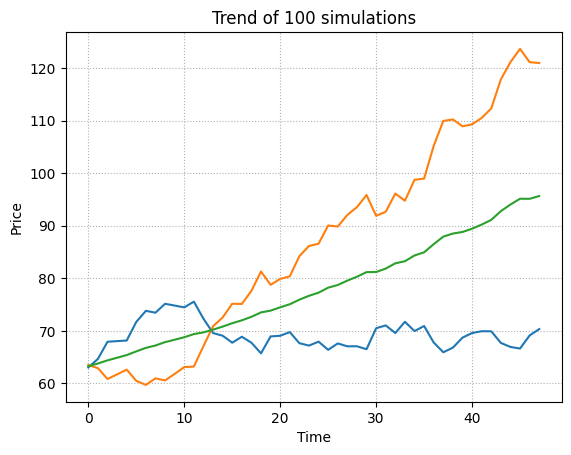

In [ ]:
midPrices = gbm_run(1, 4, 5, historical=True, plot=True, train=False)
#midP = gbm_run(1, 4, 5, historical=False, plot=False, train=False)
#midP

In [ ]:
def volatility_as_float(vol):
  vol = vol.split(",")
  vol = vol[0] + "." + vol[1]
  vol = float(vol)
  return vol

def price_as_float(price):
  price = price.split(",")
  price = price[0] + "." + price[1]
  price = float(price)
  return price

Now we have plot our simulations over time.

It is interesting to note that the first values at time 0 are slightly different.

Moreover we have defined the ```gbm_run()``` function that will allow us to make different simulations whenever we want.



In [ ]:
import numpy as np
import random

class orderBook:
  def __init__(self, midP, volatility):
      '''
      The class orderBook generates an orderBook given a midPrice around which
      bid and ask orders will take place. Thanks to the GBM we have a
      correlation on the evolution of the midPrice for each timestep and this
      way we are able to use for our gym environment.

      ADDED:
      -no more duplicates
      -random noise on std_dev
      -random selection with higher probability for higher values in bids and lower values in asks
      '''
      self.midPrice = midP
      self.volatility = volatility
      self.percentage = 0.1 # 10% noise

      #std_dev = volatility * mean
      self.std_dev = self.volatility * self.midPrice
      # add noise to std_dev
      self.noise = np.random.normal(loc=0, scale=self.std_dev * self.percentage)
      self.noisy_std_dev = self.std_dev + self.noise

      # bid and ask orders generated using normal distribution with mean=midPrice
      # and std_dev given by previous formula. 50 random orders are generated then 5 are selected; no duplicates allowed!
      self.bid_values = np.random.normal(loc=self.midPrice, scale=self.noisy_std_dev, size=50)
      self.bid_values = np.unique(self.bid_values)

      self.ask_values = np.random.normal(loc=self.midPrice, scale=self.noisy_std_dev, size=50)
      self.ask_values = np.unique(self.ask_values)

      # filter values lower for bids and greater for asks then rounded to 2nd decimal
      self.bid_values = [round(x,2) for x in self.bid_values if x < self.midPrice]
      self.bid_values.sort()
      self.ask_values = [round(x,2) for x in self.ask_values if x > self.midPrice]
      self.ask_values.sort()


      # select 5 values using random.choices() knowing that higher values are more likely to be taken
      n = 5 # number of values to select

      self.total_bid = sum(self.bid_values)
      if self.total_bid <= 0:
        self.total_bid = 1
      # self.bid_weights = [bid / self.total_bid for bid in self.bid_values]
      self.bid_weights = [0.01 if bid <= 0 else bid / self.total_bid for bid in self.bid_values]
      self.bid_result = []
      for _ in range(n):
        self.bid_choice = random.choices(self.bid_values, weights=self.bid_weights)[-1]
        self.bid_result.append(self.bid_choice)
        index = self.bid_values.index(self.bid_choice)
        self.bid_values.pop(index)
        self.bid_weights.pop(index)
      self.bid_result.sort()


      # select 5 values using random.choices() knowing that lower values are more likely to be taken
      self.total_ask = sum([1/x for x in self.ask_values])
      self.ask_weights = [ (1/ask) / self.total_ask for ask in self.ask_values]
      self.ask_result = []
      for _ in range(n):
        self.ask_choice = random.choices(self.ask_values, weights=self.ask_weights)[0]
        self.ask_result.append(self.ask_choice)
        index = self.ask_values.index(self.ask_choice)
        self.ask_values.pop(index)
        self.ask_weights.pop(index)
      self.ask_result.sort()

      # generation of a volume multiple of 0.25 for each level [0.25; 3]
      for i in range(5):
        self.bid_result[i] = (self.bid_result[i], random.randint(1, 12) * 0.25)
        self.ask_result[i] = (self.ask_result[i], random.randint(1, 12) * 0.25)


      # orderbook as a list of bids and asks
      self.orderbook = [self.bid_result, self.ask_result]

  # utility to print the order book
  def printBook(self):
    print("Bids")
    print("Price | Volume")
    for i in range(5):
        print("Bid", i, ":", self.orderbook[0][i])
    print("------------------\n")
    print("Asks")
    print("Price | Volume")
    for i in range(5):
        print("Ask", i, ":", self.orderbook[1][i])
    print("\n")

  # get best bid and ask with the respective volume
  def get_tob(self):
    return self.orderbook[0][4], self.orderbook[1][0]

In [ ]:
ob = orderBook(midPrices[0], 0.176)
print(f'mid price: {midPrices[0]}')
ob.printBook()
tob = ob.get_tob()

mid price: 63.275
Bids
Price | Volume
Bid 0 : (53.13, 2.25)
Bid 1 : (56.84, 0.25)
Bid 2 : (59.74, 0.25)
Bid 3 : (60.44, 1.0)
Bid 4 : (60.53, 2.5)
------------------

Asks
Price | Volume
Ask 0 : (63.9, 1.75)
Ask 1 : (66.98, 1.25)
Ask 2 : (67.62, 3.0)
Ask 3 : (68.06, 3.0)
Ask 4 : (70.17, 0.25)




Now we try to use XGB for the forecast of the eletricity price.

In [ ]:
from datetime import datetime, time

# define a function that generates a transaction df from midPrices dataframe
def generate_transaction_data(df, std_dev, date, length):
  start_datetime = datetime.strptime(date + " 10:00:00", "%Y-%m-%d %H:%M:%S")
  end_datetime = datetime.strptime(date + " 14:00:00", "%Y-%m-%d %H:%M:%S")

  # create a df with generated data
  output_df = pd.DataFrame(columns=['Transaction_ID', 'Transaction_Price', 'Execution_Time'])

  current_start = start_datetime
  current_end = current_start + timedelta(minutes=length)

  # iterate over input dataframe rows: for each hour price insert from 1 to 3 transactions
  for value in df:
    num_transactions = np.random.randint(1,3)
    transaction_prices = [np.random.normal(loc=value, scale=std_dev) for _ in range(num_transactions)]
    result_times = []

    while len(result_times) < num_transactions:
      new_datetime = current_start + random.random() * (current_end - current_start)
      if new_datetime not in result_times:
        result_times.append(new_datetime)

    #execution_times = [start_datetime + timedelta(minutes=np.random.randint(0,delta)) for _ in range(num_transactions)]
    temp_df = pd.DataFrame({'Transaction_Price': transaction_prices,
                           'Execution_Time': result_times})
    output_df = pd.concat([output_df, temp_df], ignore_index=True)
    output_df["Execution_Time"] = pd.to_datetime(output_df["Execution_Time"]).dt.strftime('%Y-%m-%d %H:%M:%S')
    current_start += timedelta(minutes=length)
    current_end += timedelta(minutes=length)

  output_df.sort_values(by='Execution_Time', inplace=True)
  output_df.reset_index(drop=True, inplace=True)
  # add columns and make operations to scale prices in [-1,1]
  # compute the daily mean for each day
  output_df['Execution_Time'] = pd.to_datetime(output_df['Execution_Time'])

  # discretize each 5 mins and take the mean
  output_df = output_df.set_index('Execution_Time')
  output_df = output_df.resample('5T')['Transaction_Price'].mean().reset_index()
  output_df.columns = ['Execution_Time', 'Transaction_Price']

  output_df['Transaction_ID'] = range(1, len(output_df) + 1)
  output_df['Daily_Mean'] = output_df.groupby(output_df['Execution_Time'].dt.date)['Transaction_Price'].transform('mean')
  return output_df

def build_framework(output_df):
  # insert column Hour and WeekDay
  output_df['Hour'] = output_df['Execution_Time'].dt.hour
  output_df['Month'] = output_df['Execution_Time'].dt.month
  output_df['Week of the Year'] = output_df['Execution_Time'].dt.isocalendar().week
  output_df['Weekday'] = output_df['Execution_Time'].dt.weekday + 1
  output_df['Quarter'] = output_df['Month'].apply(month_to_quarter)

  # constant = 3

  output_df['Date'] = output_df['Execution_Time'].dt.date
  daily_mean = output_df.groupby('Date')['Transaction_Price'].mean().reset_index(name='Daily_Mean')
  daily_mean['Prev_Daily_Mean'] = daily_mean['Daily_Mean'].shift()

  output_df = pd.merge(output_df, daily_mean[['Date', 'Prev_Daily_Mean']], on='Date', how='left')
  output_df = output_df.drop('Date', axis=1)

  # exclude first day in the df
  first_day = output_df['Execution_Time'].dt.date.min()
  output_df = output_df[output_df["Execution_Time"].dt.date != first_day]

  # reset IDs
  output_df['Transaction_ID'] = range(1, len(output_df) + 1)

  # select only columns i'm interested in
  output_df = output_df[['Transaction_ID', 'Transaction_Price', 'Execution_Time', 'Daily_Mean', 'Prev_Daily_Mean',
                          'Hour', 'Weekday', 'Week of the Year', 'Month', 'Quarter']]
  # reset index of df to 0
  output_df = output_df.reset_index(drop=True)
  return output_df

def month_to_quarter(month):
  if month in [1, 2, 3]:
    return 1 # Winter
  elif month in [4, 5, 6]:
    return 2 # Spring
  elif month in [7, 8, 9]:
    return 3 # Summer
  else:
    return 4 # Autumn


Generate a 6 months prices simulation

In [ ]:
framework = pd.DataFrame(columns=['Transaction_ID', 'Transaction_Price', 'Execution_Time', 'Daily_Mean', 'Prev_Daily-Mean'])
start_date = datetime(2019, 7, 1)

for i in range(len(prices_2019_df)):
  daily_prices_simulation = gbm_run(i+1, 4, 5, historical=True, plot=False, train=False)
  transaction_data_df = generate_transaction_data(daily_prices_simulation, daily_prices_simulation.std(), start_date.strftime("%Y-%m-%d"), 5)
  start_date += timedelta(days=1)
  framework = pd.concat([framework, transaction_data_df], ignore_index=True)

framework = build_framework(framework)


In [ ]:
framework


,Transaction_ID,Transaction_Price,Execution_Time,Daily_Mean,Prev_Daily_Mean,Hour,Weekday,Week of the Year,Month,Quarter
0,1,47.697639,2019-07-02 10:00:00,78.070168,76.764593,10,2,27,7,3
1,2,70.602777,2019-07-02 10:05:00,78.070168,76.764593,10,2,27,7,3
2,3,74.098092,2019-07-02 10:10:00,78.070168,76.764593,10,2,27,7,3
3,4,58.154837,2019-07-02 10:15:00,78.070168,76.764593,10,2,27,7,3
4,5,63.745472,2019-07-02 10:20:00,78.070168,76.764593,10,2,27,7,3
...,...,...,...,...,...,...,...,...,...,...
8779,8780,66.524634,2019-12-31 13:35:00,53.553960,45.703414,13,2,1,12,4
8780,8781,65.772546,2019-12-31 13:40:00,53.553960,45.703414,13,2,1,12,4
8781,8782,78.583032,2019-12-31 13:45:00,53.553960,45.703414,13,2,1,12,4
8782,8783,72.693788,2019-12-31 13:50:00,53.553960,45.703414,13,2,1,12,4


### Build the framework for XGB
Now we have Transaction Data and orderbook data and we build the framework that is going to be used in the XGB

In [ ]:
# here i insert coherent orderbooks for each transaction
# transaction_data_df = generate_transaction_data(historical_prices, historical_prices.std())
def compute_vwap(orderbook):
  total_volume = 0
  weighted_sum = 0
  for side in orderbook:
    for price, volume in side:
      total_volume += volume
      weighted_sum += price * volume
  vwap = weighted_sum / total_volume
  return vwap

historical_data = framework.copy()
columns = ['Ask level 1', 'Ask level 2', 'Ask level 3', 'Ask level 4', 'Ask level 5',
           'Bid level 1', 'Bid level 2', 'Bid level 3', 'Bid level 4', 'Bid level 5',
           'Spread', 'Available Trading Volume', 'Volume Weighted Price']
for col in columns:
  historical_data[col] = None
#print(historical_data)

for i in range(len(historical_data)):
  ob = orderBook(historical_data.loc[i, "Daily_Mean"], historical_data['Transaction_Price'].std()/historical_data.loc[i, "Daily_Mean"])
  # here i change the transaction with the closest bid/ask order in the orderbook
  if historical_data.loc[i, "Transaction_Price"] > historical_data.loc[i, "Daily_Mean"]:
    # check in asks -> orderbook[1]
    min_index = min(range(len(ob.orderbook[1])), key=lambda x: abs(ob.orderbook[1][x][0] - historical_data.loc[i, "Transaction_Price"]))
    order = ob.orderbook[1][min_index][0]
    ob.orderbook[1][min_index] = (round(historical_data.loc[i, "Transaction_Price"],2), ob.orderbook[1][min_index][1])

  else: # same for bids
    min_index = min(range(len(ob.orderbook[0])), key=lambda x: abs(ob.orderbook[0][x][0] - historical_data.loc[i, "Transaction_Price"]))
    order = ob.orderbook[0][min_index][0]
    ob.orderbook[0][min_index] = (round(historical_data.loc[i, "Transaction_Price"],2), ob.orderbook[0][min_index][1])

  # insert checks to best bid / ask and change it
  volume_tot = 0
  historical_data.at[i, 'Bid level 1'] = ob.orderbook[0][4][0]
  volume_tot += ob.orderbook[0][4][1]
  historical_data.at[i, 'Bid level 2'] = ob.orderbook[0][3][0]
  volume_tot += ob.orderbook[0][3][1]
  historical_data.at[i, 'Bid level 3'] = ob.orderbook[0][2][0]
  volume_tot += ob.orderbook[0][2][1]
  historical_data.at[i, 'Bid level 4'] = ob.orderbook[0][1][0]
  volume_tot += ob.orderbook[0][1][1]
  historical_data.at[i, 'Bid level 5'] = ob.orderbook[0][0][0]
  volume_tot += ob.orderbook[0][0][1]
  historical_data.at[i, 'Ask level 1'] = ob.orderbook[1][0][0]
  volume_tot += ob.orderbook[1][0][1]
  historical_data.at[i, 'Ask level 2'] = ob.orderbook[1][1][0]
  volume_tot += ob.orderbook[1][1][1]
  historical_data.at[i, 'Ask level 3'] = ob.orderbook[1][2][0]
  volume_tot += ob.orderbook[1][2][1]
  historical_data.at[i, 'Ask level 4'] = ob.orderbook[1][3][0]
  volume_tot += ob.orderbook[1][3][1]
  historical_data.at[i, 'Ask level 5'] = ob.orderbook[1][4][0]
  volume_tot += ob.orderbook[1][4][1]
  historical_data.at[i, 'Spread'] = ob.orderbook[1][0][0] - ob.orderbook[0][4][0]
  historical_data.at[i, "Available Trading Volume"] = volume_tot
  vwap = compute_vwap(ob.orderbook)
  historical_data.at[i, "Volume Weighted Price"] = vwap


historical_data[['Ask level 1', 'Ask level 2', 'Ask level 3', 'Ask level 4', 'Ask level 5',
           'Bid level 1', 'Bid level 2', 'Bid level 3', 'Bid level 4', 'Bid level 5',
           'Spread', 'Available Trading Volume', 'Volume Weighted Price']] = historical_data[['Ask level 1', 'Ask level 2', 'Ask level 3', 'Ask level 4', 'Ask level 5',
           'Bid level 1', 'Bid level 2', 'Bid level 3', 'Bid level 4', 'Bid level 5',
           'Spread', 'Available Trading Volume', 'Volume Weighted Price']].astype(float)
historical_data[['Hour', 'Weekday', 'Week of the Year', 'Month', 'Quarter']] = historical_data[['Hour', 'Weekday', 'Week of the Year', 'Month', 'Quarter']].astype(int)


In [ ]:
# historical_data.dtypes
historical_data

,Transaction_ID,Transaction_Price,Execution_Time,Daily_Mean,Prev_Daily_Mean,Hour,Weekday,Week of the Year,Month,Quarter,...,Ask level 4,Ask level 5,Bid level 1,Bid level 2,Bid level 3,Bid level 4,Bid level 5,Spread,Available Trading Volume,Volume Weighted Price
0,1,47.697639,2019-07-02 10:00:00,78.070168,76.764593,10,2,27,7,3,...,85.72,88.42,77.02,66.38,65.53,64.78,47.70,1.93,14.75,73.956271
1,2,70.602777,2019-07-02 10:05:00,78.070168,76.764593,10,2,27,7,3,...,94.59,107.92,73.30,70.60,67.97,66.76,60.41,8.78,15.50,78.552258
2,3,74.098092,2019-07-02 10:10:00,78.070168,76.764593,10,2,27,7,3,...,97.82,100.74,74.10,69.58,66.04,64.01,53.82,5.91,18.25,79.090959
3,4,58.154837,2019-07-02 10:15:00,78.070168,76.764593,10,2,27,7,3,...,86.72,89.62,77.11,61.79,58.15,54.78,46.29,1.69,11.00,70.323864
4,5,63.745472,2019-07-02 10:20:00,78.070168,76.764593,10,2,27,7,3,...,93.33,98.94,75.01,71.66,63.75,62.31,51.98,6.96,20.75,77.466265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,8780,66.524634,2019-12-31 13:35:00,53.553960,45.703414,13,2,1,12,4,...,66.52,75.09,48.90,47.85,39.87,36.64,33.15,8.43,18.00,53.385417
8780,8781,65.772546,2019-12-31 13:40:00,53.553960,45.703414,13,2,1,12,4,...,58.22,65.77,51.41,42.42,40.04,39.17,35.71,3.00,15.25,47.304754
8781,8782,78.583032,2019-12-31 13:45:00,53.553960,45.703414,13,2,1,12,4,...,71.41,78.58,46.64,43.93,40.37,36.43,28.62,7.66,20.75,51.097108
8782,8783,72.693788,2019-12-31 13:50:00,53.553960,45.703414,13,2,1,12,4,...,66.67,72.69,48.84,45.97,44.89,38.48,35.13,5.01,13.00,56.129615


In [ ]:
historical_data.columns
#historical_data.to_csv('Historical_2019.csv')

Index(['Transaction_ID', 'Transaction_Price', 'Execution_Time', 'Daily_Mean',
       'Prev_Daily_Mean', 'Hour', 'Weekday', 'Week of the Year', 'Month',
       'Quarter', 'Ask level 1', 'Ask level 2', 'Ask level 3', 'Ask level 4',
       'Ask level 5', 'Bid level 1', 'Bid level 2', 'Bid level 3',
       'Bid level 4', 'Bid level 5', 'Spread', 'Available Trading Volume',
       'Volume Weighted Price'],
      dtype='object')

Mean Absolute Error: 5.849118233569626
Root mean square error: 7.1339022657166735
Weighted Absolute Percentage Error: 0.09661206515468455


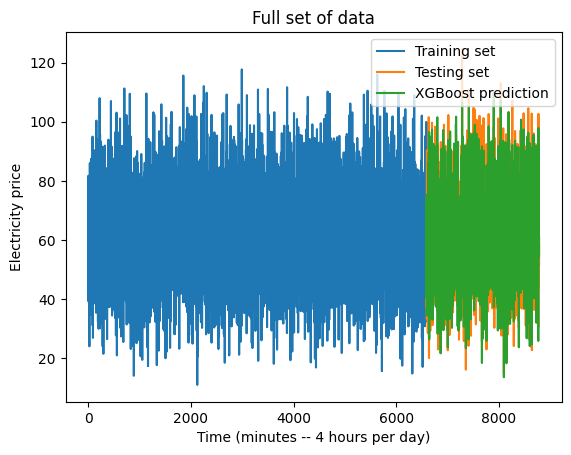

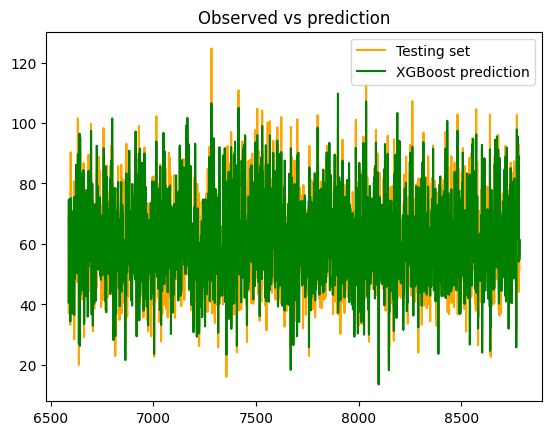

[40.63512  74.64617  50.97148  ... 61.580875 54.80475  61.185925]


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# test without normalization
# X = historical_data.drop(['Execution_Time'], axis = 1)
X = historical_data.drop(['Execution_Time', 'Transaction_Price',
                          'Volume Weighted Price'], axis = 1)

# select target
y = historical_data.Transaction_Price

#separate data into training and validation sets for test purposes
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

xgb_model = XGBRegressor(colsample_bytree=0.82, gamma=0.01, learning_rate=0.11,
                         max_depth=6, n_estimators=187)

# fit the model to the training data
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_valid)
# print(X_valid.dtypes)
xgb_forecast = predictions.reshape(-1,1)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
print("Root mean square error: " + str(np.sqrt(mean_squared_error(predictions, y_valid))))
print("Weighted Absolute Percentage Error: " + str(sum(abs(y_valid-predictions)) / sum(abs(y_valid))))

%matplotlib inline
s = len(y_train)
e = len(y_train)+len(y_valid)
plt.plot(np.arange(s), y_train)
plt.plot(np.arange(s, e), y_valid)
plt.plot(np.arange(s, e), xgb_forecast)
plt.title("Full set of data")
plt.ylabel("Electricity price")
plt.xlabel("Time (minutes -- 4 hours per day)")
plt.legend(["Training set", "Testing set", "XGBoost prediction"])
plt.show()
plt.plot(np.arange(s, e), y_valid, color = "orange")
plt.plot(np.arange(s, e), xgb_forecast, color = "green")
plt.title("Observed vs prediction")
plt.legend(["Testing set", "XGBoost prediction"])
plt.show()
print(predictions)

In [ ]:
historical_data.drop(["Transaction_Price", "Execution_Time"], axis=1)

,Transaction_ID,Daily_Mean,Prev_Daily_Mean,Hour,Weekday,Week of the Year,Month,Quarter,Ask level 1,Ask level 2,...,Ask level 4,Ask level 5,Bid level 1,Bid level 2,Bid level 3,Bid level 4,Bid level 5,Spread,Available Trading Volume,Volume Weighted Price
0,1,78.070168,76.764593,10,2,27,7,3,78.95,79.19,...,85.72,88.42,77.02,66.38,65.53,64.78,47.70,1.93,14.75,73.956271
1,2,78.070168,76.764593,10,2,27,7,3,82.08,82.45,...,94.59,107.92,73.30,70.60,67.97,66.76,60.41,8.78,15.50,78.552258
2,3,78.070168,76.764593,10,2,27,7,3,80.01,80.08,...,97.82,100.74,74.10,69.58,66.04,64.01,53.82,5.91,18.25,79.090959
3,4,78.070168,76.764593,10,2,27,7,3,78.80,78.81,...,86.72,89.62,77.11,61.79,58.15,54.78,46.29,1.69,11.00,70.323864
4,5,78.070168,76.764593,10,2,27,7,3,81.97,84.75,...,93.33,98.94,75.01,71.66,63.75,62.31,51.98,6.96,20.75,77.466265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,8780,53.553960,45.703414,13,2,1,12,4,57.33,61.26,...,66.52,75.09,48.90,47.85,39.87,36.64,33.15,8.43,18.00,53.385417
8780,8781,53.553960,45.703414,13,2,1,12,4,54.41,56.03,...,58.22,65.77,51.41,42.42,40.04,39.17,35.71,3.00,15.25,47.304754
8781,8782,53.553960,45.703414,13,2,1,12,4,54.30,57.15,...,71.41,78.58,46.64,43.93,40.37,36.43,28.62,7.66,20.75,51.097108
8782,8783,53.553960,45.703414,13,2,1,12,4,53.85,56.32,...,66.67,72.69,48.84,45.97,44.89,38.48,35.13,5.01,13.00,56.129615


Create an XGB model trained on historical data from 1/6/2019 to 30/12/2019 that will be used in Gym environment

In [ ]:
xgb_model = XGBRegressor(colsample_bytree=0.82, gamma=0.01, learning_rate=0.11,
                         max_depth=6, n_estimators=187)

X = historical_data.drop(["Transaction_Price", "Execution_Time",
                          'Volume Weighted Price'], axis=1)
y = historical_data.Transaction_Price

xgb_model.fit(X, y)

# add forecast to the last row
last_row = historical_data.iloc[-1]
last_row = last_row.drop(['Transaction_Price', 'Execution_Time',
                              'Volume Weighted Price'])
forecast = xgb_model.predict(last_row.values.reshape(1,-1))
historical_data.at[historical_data.index[-1], 'Forecast'] = forecast

In [ ]:
historical_data

,Transaction_ID,Transaction_Price,Execution_Time,Daily_Mean,Prev_Daily_Mean,Hour,Weekday,Week of the Year,Month,Quarter,...,Ask level 5,Bid level 1,Bid level 2,Bid level 3,Bid level 4,Bid level 5,Spread,Available Trading Volume,Volume Weighted Price,Forecast
0,1,47.697639,2019-07-02 10:00:00,78.070168,76.764593,10,2,27,7,3,...,88.42,77.02,66.38,65.53,64.78,47.70,1.93,14.75,73.956271,NaN
1,2,70.602777,2019-07-02 10:05:00,78.070168,76.764593,10,2,27,7,3,...,107.92,73.30,70.60,67.97,66.76,60.41,8.78,15.50,78.552258,NaN
2,3,74.098092,2019-07-02 10:10:00,78.070168,76.764593,10,2,27,7,3,...,100.74,74.10,69.58,66.04,64.01,53.82,5.91,18.25,79.090959,NaN
3,4,58.154837,2019-07-02 10:15:00,78.070168,76.764593,10,2,27,7,3,...,89.62,77.11,61.79,58.15,54.78,46.29,1.69,11.00,70.323864,NaN
4,5,63.745472,2019-07-02 10:20:00,78.070168,76.764593,10,2,27,7,3,...,98.94,75.01,71.66,63.75,62.31,51.98,6.96,20.75,77.466265,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,8780,66.524634,2019-12-31 13:35:00,53.553960,45.703414,13,2,1,12,4,...,75.09,48.90,47.85,39.87,36.64,33.15,8.43,18.00,53.385417,NaN
8780,8781,65.772546,2019-12-31 13:40:00,53.553960,45.703414,13,2,1,12,4,...,65.77,51.41,42.42,40.04,39.17,35.71,3.00,15.25,47.304754,NaN
8781,8782,78.583032,2019-12-31 13:45:00,53.553960,45.703414,13,2,1,12,4,...,78.58,46.64,43.93,40.37,36.43,28.62,7.66,20.75,51.097108,NaN
8782,8783,72.693788,2019-12-31 13:50:00,53.553960,45.703414,13,2,1,12,4,...,72.69,48.84,45.97,44.89,38.48,35.13,5.01,13.00,56.129615,NaN


# Gym Environment - Reinforcement Learning as Markov Decision Process
Since we have a 5-level orderbook , we can employ it in our gym environment as part of the observation and action space. The orders that will be posted won't affect the price's course because of the small traded volume (from 0.25 to 1.0 MW/h).

For a better comprehension use this link: https://doi.org/10.48550/arXiv.2111.13609.

From now on at each timestep we'll generate a new orderbook we are going to take the mid-price from the already-built dataframe; this way we keep the time correlation between prices.

---

| Variable Group | Variables                                                 |
|----------------|-----------------------------------------------------------|
|                |Current and previous volume weighted electricity price(1-2)|
|                |Day-ahead price(3)                                         |
| Price variables|Forecast of electricity price(4)                           |
|                |Current and previous difference between price and forecast(5-6)|                |Portfolio price of the current volume(7)                   |
|                |Price Maker(8)                                             |
|                |                                                           |
|                |Forecast of the production volume(9)                       |
|Volume variables|Current volume of the trading agent(10)                    |
|                |Difference of the current volume and producion volume(11)  |
|                |                                                           |
|Episode Variable|Time to end(12)                                            |
|                |                                                           |

In [ ]:
!pip install stable-baselines3[extra]
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install gym --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRele

In [ ]:
import pytz
class TradingStats():
  '''
  External class used to perform all stats functions, exports, plots and so on
  '''

  def __init__(self):
    self.sars_df = pd.DataFrame(columns=['State', 'Action', 'Reward', 'Next State'])
    self.sars_df.loc[0] = [0, 0, 0, 0]
    self.absolute_volume_traded = 0
    self.volume_traded = 0
    self.balance = 0
    self.cum_reward = 0
    self.trading_df = pd.DataFrame(columns=['Episode', 'Step', 'Action Type', 'Action Price', 'Matched', 'Transaction',
                                            'Volume Traded', 'Absolute Volume Traded', 'Balance'])

  def update_stats(self, volume, price, o_type, o_price, matched):
    self.absolute_volume_traded += abs(volume)
    self.volume_traded += volume
    update_row = {'Action Type': o_type, 'Action Price': o_price, 'Matched': matched,
                  'Transaction': round(abs(price),2), 'Volume Traded': self.volume_traded,
                  'Absolute Volume Traded': self.absolute_volume_traded,
                  'Balance': round(self.balance,2)}
    update_row = pd.DataFrame(update_row, index=[0])
    self.trading_df = pd.concat([self.trading_df, update_row],ignore_index=True)

  def compute_balance(self):
    # for debugging purpose --> self.trading_df.loc[self.trading_df.index[-1], 'Volume Traded'] = 0
    self.balance = 0
    if self.trading_df.loc[self.trading_df.index[-1], 'Volume Traded'] == 0:
      self.balance = ((self.trading_df['Action Type'] * -1) * self.trading_df['Transaction']).tail(48).sum()

    self.trading_df.loc[self.trading_df.index[-1], 'Balance'] = self.balance

  def compute_final_trading_df(self):
    self.total_steps = 48
    self.trading_df['Episode'] = (self.trading_df.index // self.total_steps) + 1
    self.trading_df['Step'] = (self.trading_df.index % self.total_steps) + 1
    #self.trading_df['Balance x Episode'] = np.zeros(len(self.trading_df))
    #self.trading_df.loc[47::48, 'Balance x Episode'] = self.trading_df.loc[47::48, 'Balance'].values - self.trading_df.loc[46::48, 'Balance'].values
    self.trading_df['Cumulative Balance'] = np.zeros(len(self.trading_df))
    self.trading_df.loc[47::48, 'Cumulative Balance'] = self.trading_df.loc[47::48, 'Balance'].cumsum()
    self.trading_df['Reward x Episode'] = np.zeros(len(self.trading_df))
    self.trading_df.loc[47::48, 'Reward x Episode'] = self.trading_df.loc[47::48, 'Cumulative Reward'].values

  def add_reward(self, reward):
    self.cum_reward += reward
    # self.cum_reward += self.trading_df.loc[self.trading_df.index[-1], 'Volume Reward']
    self.trading_df.loc[self.trading_df.index[-1], "Actual Reward"] = reward
    self.trading_df.loc[self.trading_df.index[-1], "Cumulative Reward"] = self.cum_reward

  def update_gym_log(self, state, action, reward, new_state):
    data = {
        'State': [state],
        'Action': [action],
        'Reward': [reward],
        'Next State': [new_state]
    }
    new_row = pd.DataFrame.from_dict(data)
    self.sars_df = pd.concat([self.sars_df, new_row], ignore_index=True)

In [ ]:
import gymnasium as gym
from gym.spaces import Box, Discrete, Tuple
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import os
import shutil


class TradingEnv(gym.Env):
  """
  Trading Environment for gym
  """
  #da_price is the day-ahead price and is constant
  def __init__(self, data, stats, mid_prices, env_name):
    super(TradingEnv, self).__init__()

    self.stats = stats
    self.data = data
    self.current_step = None
    self.mid_prices = mid_prices

    # for export
    self.env_name = env_name
    rome_tz = pytz.timezone('Europe/Rome')
    now = datetime.now(rome_tz)
    self.date_string = now.strftime('%Y%m%d')
    self.time_string = now.strftime('%H%M%S')
    self.path = f'{self.env_name}_RESULTS_{self.date_string}_{self.time_string}/'
    if not os.path.exists(self.path):
      os.makedirs(self.path)

    # Discrete = -1 --> buy, 0 --> hold, 1 --> sell
    # Continous = [0,1] --> traded price
    # self.action_space = Tuple((Discrete(3, start=-1), Box(low=0, high=1, shape=(1,), dtype=np.float32)))
    self.action_space = gym.spaces.Box(low=np.array([-1, 0], dtype=np.float32), high=np.array([1, 1], dtype=np.float32), dtype=np.float32)
    # observation space
    self.low = np.array([0, 0, 0, 0, 0, -np.inf, -np.inf, -1, -np.inf, 0, 0], dtype=np.float32)
    self.high = np.array([np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1, np.inf, np.inf, 48], dtype=np.float32)
    self.observation_space = gym.spaces.Box(low = self.low, high = self.high, dtype=np.float32)

  def _next_observation(self, xgb_model, prices, day):
    self.current_vwap = compute_vwap(self.ob.orderbook)
    if self.current_step == 1:
      self.previous_vwap = 0
      self.previous_forecast = 0
    else:
      self.previous_vwap = self.data.iloc[-2]['Volume Weighted Price']
      self.previous_forecast = self.data.iloc[-2]['Forecast']

    self.day_ahead_price = self.mid_prices[day]
    self.day_ahead_price = price_as_float(self.day_ahead_price)
    last_row = self.data.iloc[-1].copy()
    last_row = last_row.drop(['Transaction_Price', 'Execution_Time',
                              'Volume Weighted Price', 'Forecast'])
    self.current_forecast = xgb_model.predict(last_row.values.reshape(1,-1))
    self.data.at[self.data.index[-1], 'Forecast'] = self.current_forecast


    self.current_diff = self.current_vwap - self.current_forecast
    self.previous_diff = self.previous_vwap - self.previous_forecast
    if self.current_diff > 0 and self.previous_diff > 0:
      self.price_maker = 1
    elif self.current_diff < 0 and self.previous_diff < 0:
      self.price_maker = -1
    else:
      self.price_maker = 0
    self.absolute_current_volume = self.stats.absolute_volume_traded
    self.current_volume = self.stats.volume_traded
    self.time_to_end = 1 - self.current_step / len(prices)

    frame = {
    'current_vwap': [self.current_vwap],
    'previous_vwap': [self.previous_vwap],
    'day_ahead_price': [self.day_ahead_price],
    'current_forecast': [self.current_forecast],
    'previous_forecast': [self.previous_forecast],
    'current_diff': [self.current_diff],
    'previous_diff': [self.previous_diff],
    'price_maker': [self.price_maker],
    'absolute_current_volume': [self.absolute_current_volume],
    'current_volume': [self.current_volume],
    'time_to_end': [self.time_to_end]
    }
    return frame

  def step(self, action, prices, volatility, xgb_model, day):
    # execute one time step within the environment where it generates all data needed for step and observations
    action = list(action)
    if action[0] >= -1 and action[0] <= -0.33:
      action[0] = -1
    elif action[0] > -0.33 and action[0] < 0.33:
      action[0] = 0
    else:
      action[0] = 1

    self._execute_action(action, prices, volatility)
    reward = 0.
    self.current_step += 1

    done = self.current_step >= len(prices)
    if done:
      self.stats.compute_balance()
    # update obs space w/ new obs
    new_state = self._next_observation(xgb_model, prices, day)

    # create an array from dict for stablebaseline
    new_state_array = np.array(list(new_state.values()), dtype=np.float32).ravel()
    # print(f'obs: {new_state_array}')
    reward += self._compute_reward(action, prices)
    if self.current_step - 1 == 0:
      self.stats.update_gym_log(self.reset_array, action, reward, new_state_array)
    else:
      self.stats.update_gym_log(self.stats.sars_df.iloc[-1]['Next State'], action, reward, new_state_array)

    truncated = False
    return new_state_array, reward, done, truncated, {}

  def reset(self, day, length):
    self.stats.cum_reward = 0
    self.stats.volume_traded = 0
    self.stats.absolute_volume_traded = 0
    # price variables
    self.current_step = 0
    self.previous_vwap = 0
    self.current_vwap = 0
    self.day_ahead_price = self.mid_prices[day]
    self.day_ahead_price = price_as_float(self.day_ahead_price)
    self.current_forecast = 0
    self.previous_forecast = 0
    self.current_diff = 0
    self.previous_diff = 0
    self.price_maker = 0
    # volume variables
    self.absolute_current_volume = 0
    self.current_volume = 0
    # episode variable
    self.time_to_end = length

    frame = {
    'current_vwap': [self.current_vwap],
    'previous_vwap': [self.previous_vwap],
    'day_ahead_price': [self.day_ahead_price],
    'current_forecast': [self.current_forecast],
    'previous_forecast': [self.previous_forecast],
    'current_diff': [self.current_diff],
    'previous_diff': [self.previous_diff],
    'price_maker': [self.price_maker],
    'absolute_current_volume': [self.absolute_current_volume],
    'current_volume': [self.current_volume],
    'time_to_end': [self.time_to_end]
    }

    frame_array = np.array(list(frame.values()), dtype=np.float32).ravel()
    # print(f'reset frame: {frame_array}')
    self.reset_array = frame_array
    return frame_array, {}

  def _compute_reward(self, action, prices):
    self.current_price = self.stats.trading_df['Transaction'].iloc[-1] / 1000
    if self.stats.trading_df['Matched'].iloc[-1] == "True":
      self.actual_volume = self.stats.trading_df["Action Type"].iloc[-1]
    else:
      self.actual_volume = 0
    self.cost_fee = 0
    self.trade_reward = -self.current_price * self.actual_volume - self.cost_fee * abs(self.actual_volume)
    #self.trade_reward = self.trade_reward

    self.volume_reward = 0

    if self.current_step == len(prices):
      self.volume_penalty = self.stats.trading_df.iloc[-1]["Volume Traded"]
      self.volume_reward = - 0.1 * (self.volume_penalty ** 2)
      '''factor = 0.0
      penalty = 4 # poi 40
      if self.stats.absolute_volume_traded == 0:
        factor = - 0.1 * (penalty ** 2)
      self.volume_reward += factor'''

    self.stats.trading_df.loc[self.stats.trading_df.index[-1], "Trade Reward"] = self.trade_reward
    self.stats.trading_df.loc[self.stats.trading_df.index[-1], "Volume Reward"] = self.volume_reward

    self.final_reward = (self.trade_reward + self.volume_reward)

    self.stats.add_reward(self.final_reward)
    return self.final_reward

    '''---DUMMY REWARDING FOR TESTING---
    if action[0] >= -1 and action[0] <= -0.33:
      self.dummy = 1
    else:
      self.dummy = -1
    # update stats with reward
    self.stats.add_reward(self.dummy)
    return self.dummy
    ---END---'''

  def _execute_action(self, action, prices, volatility):
    # prices and volatility are passed as input to the gym
    self.ob = orderBook(prices[self.current_step], volatility)
    self._process_order(action, self.ob, prices[self.current_step], volatility)


  def _process_order(self, action, ob, price, volatility):
    '''
    Wrappper; this method simply call right functions to handle the new order
    '''
    order_type, order_price = action
    transaction_price = 0
    # convert to normalized to natural price in range [lowest bid ; highest ask] of the actual orderbook
    order_price = order_price * 1000

    if order_type == 0: # do nothing
      self._generate_transaction(0, transaction_price, self.ob, price, volatility)
      self.stats.update_stats(0, transaction_price, order_type, order_price, "---")

    elif order_type == 1: # buy
      matched, transaction_price = self._match_order(1, order_price, self.ob)
      if matched:
        self._generate_transaction(1, transaction_price, self.ob, price, volatility)
        self.stats.update_stats(1, -transaction_price, order_type, order_price, "True")
      # else as in case 0
      else:
        self._generate_transaction(0, transaction_price, self.ob, price, volatility)
        self.stats.update_stats(0, transaction_price, order_type, order_price, "False")

    else: # sell
      matched, transaction_price = self._match_order(-1, order_price, self.ob)
      if matched:
        self._generate_transaction(-1, transaction_price, self.ob, price, volatility)
        self.stats.update_stats(-1, transaction_price, order_type, order_price, "True")
      # else as in case 0
      else:
        self._generate_transaction(0, transaction_price, self.ob, price, volatility)
        self.stats.update_stats(0, transaction_price, order_type, order_price, "False")

  def _match_order(self, order_type, order_price, ob):
    transaction_prices = []
    transaction_volumes = []
    weighted_mean_price = 0

    if order_type == 1: # buy
      if order_price < self.ob.orderbook[1][0][0]: # order can't be matched
        return False, 0
      else:
        for i in range(len(self.ob.orderbook[1])-1):
          if self.ob.orderbook[1][i][0] < order_price:
            transaction_prices.append(self.ob.orderbook[1][i][0])
            transaction_volumes.append(self.ob.orderbook[1][i][1])
          if sum(transaction_volumes) >= 1:
            weighted_mean_price = sum(v * w for v, w in zip(transaction_prices, transaction_volumes)) / sum(transaction_volumes)
            return True, weighted_mean_price
        return False, 0

    else: #sell
      if order_price > self.ob.orderbook[0][4][0]:
        return False, 0
      else:
        for i in range(len(self.ob.orderbook[0])-1, -1, -1):
          if self.ob.orderbook[0][i][0] > order_price:
            transaction_prices.append(self.ob.orderbook[0][i][0])
            transaction_volumes.append(self.ob.orderbook[0][i][1])
          if sum(transaction_volumes) >= 1:
            weighted_mean_price = sum(v * w for v, w in zip(transaction_prices, transaction_volumes)) / sum(transaction_volumes)
            return True, weighted_mean_price
        return False, weighted_mean_price


  def _generate_transaction(self, order_type, transaction_price, ob, price, volatility):
    '''
    Generate the new row to be inserted in the df with correct values
    '''
    # take necessary values from last row/rows of df and update it
    last_row = self.data.iloc[-1].copy()

    # new execution_time
    last_execution_time = self.data.iloc[-1]['Execution_Time']
    new_execution_time = None

    if last_execution_time.time() >= datetime.strptime('13:55:00', '%H:%M:%S').time():
      new_execution_time = datetime.combine(last_execution_time.date() + timedelta(days=1), datetime.strptime('10:00:00', '%H:%M:%S').time())
    else:
      new_execution_time = last_execution_time + timedelta(minutes=5)

    # new transaction ID
    new_transaction_ID = last_row['Transaction_ID'] + 1

    # new daily mean and transaction price
    if order_type == 0:
      new_transaction_price = np.random.normal(loc=price, scale=price*volatility)
    else:
      new_transaction_price = transaction_price

    if new_execution_time.time() == datetime.strptime('10:00:00', '%H:%M:%S').time():
      new_daily_mean = new_transaction_price
    else:
      last_date = self.data['Execution_Time'].iloc[-1].date()
      last_day_rows = self.data[self.data['Execution_Time'].dt.date == last_date]
      new_daily_mean = last_day_rows['Transaction_Price'].mean()
      self.data.loc[self.data['Execution_Time'].dt.date == last_date, 'Daily_Mean'] = new_daily_mean

    # new prev daily mean
    prev_day = new_execution_time - timedelta(days=1)
    prev_days_row = self.data[self.data['Execution_Time'].dt.date == prev_day.date()]
    new_prev_daily_mean = prev_days_row.iloc[0]['Daily_Mean']

    # new datetime variables
    new_hour = new_execution_time.time().hour
    new_weekday = new_execution_time.weekday()
    new_week_of_year = new_execution_time.isocalendar()[1]
    new_month = new_execution_time.month
    quarters = [1, 2, 3, 4]
    # cambiare in quarter
    month_to_quarter = {1: quarters[0], 2: quarters[0], 3: quarters[0],
                        4: quarters[1], 5: quarters[1], 6: quarters[1],
                        7: quarters[2], 8: quarters[2], 9: quarters[2],
                        10: quarters[3], 11: quarters[3], 12: quarters[3]}
    new_quarter = month_to_quarter[new_month]

    # compute the total volume
    new_total_volume = sum(volume for side in self.ob.orderbook for price, volume in side)

    # compute new volume weighted electricity price
    new_volume_weighted_price = compute_vwap(self.ob.orderbook)

    new_row = {'Transaction_ID': new_transaction_ID, 'Transaction_Price': new_transaction_price,
               'Execution_Time': new_execution_time, 'Daily_Mean': new_daily_mean,
               'Prev_Daily_Mean': new_prev_daily_mean, 'Hour': new_hour, 'Weekday': new_weekday,
               'Week of the Year': new_week_of_year, 'Month': new_month, 'Quarter': new_quarter,
               'Ask level 1': self.ob.orderbook[1][0][0],'Ask level 2': self.ob.orderbook[1][1][0],'Ask level 3': self.ob.orderbook[1][2][0],
               'Ask level 4': self.ob.orderbook[1][3][0],'Ask level 5': self.ob.orderbook[1][4][0],'Bid level 1': self.ob.orderbook[0][0][0],
               'Bid level 2': self.ob.orderbook[0][1][0],'Bid level 3': self.ob.orderbook[0][2][0],'Bid level 4': self.ob.orderbook[0][3][0],
               'Bid level 5': self.ob.orderbook[0][4][0], 'Spread': self.ob.orderbook[1][0][0]-self.ob.orderbook[0][4][0],
               'Available Trading Volume': new_total_volume, 'Volume Weighted Price': new_volume_weighted_price,
               }
    new_row = pd.DataFrame(new_row, index=[0])
    self.data = pd.concat([self.data, new_row], ignore_index=True)

  def render(self, mode='human', sample_interval=1, train=False, algo=""):
    if train:
      type_str = 'Train'
    else:
      type_str = 'Test'

    # Create folder with name indicating information passed by input
    folder_name = f'{self.path}/Plots'
    if not os.path.exists(folder_name):
      os.makedirs(folder_name)

    df_length = len(self.stats.trading_df)
    units_per_year = 48 * (90 + 91 + 92 + 92)
    total_quarters = df_length // units_per_year * 4
    remaining_units = df_length % units_per_year

    if remaining_units <= 48 * 90:
      total_quarters += 1
    elif remaining_units <= 48 * (90 + 91):
      total_quarters += 2
    elif remaining_units <= 48 * (90 + 91 + 92):
      total_quarters += 3
    elif remaining_units <= 48 * (90 + 91 + 92 + 92):
      total_quarters += 4
    elif remaining_units <= 48 * (90 + 91 + 92 + 92 + 90):
      total_quarters += 5
    else:
      total_quarters += 6

    reps = 0
    count = 0
    # print(f"reps:{reps}")

    # iterate over the total number of quarters
    for quarter in range(total_quarters):
      # cretae a new figure and subplot for each quarter
      self.fig, self.axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
      self.fig.subplots_adjust(hspace=0.5, wspace=0.5)

      if train:
        # Handle the case where train is True
        if quarter % 6 == 0:
          year = 2020
          quarter_no = 1
          start_date = '2020-01-01'
          end_date = '2020-03-31'
          start_index = (547 * 48) * reps
          end_index = start_index + 91 * 48 - 1
          count += 1
        elif quarter % 6 == 1:
          year = 2020
          quarter_no = 2
          start_date = '2020-04-01'
          end_date = '2020-06-30'
          start_index = (547 * 48) * (reps) + 48 * 91
          end_index = start_index + 91 * 48 - 1
          count += 1
        elif quarter % 6 == 2:
          year = 2020
          quarter_no = 3
          start_date = '2020-07-01'
          end_date = '2020-09-30'
          start_index = (547 * 48) * (reps) + 48 * 91 + 48 * 91
          end_index = start_index + 92 * 48 - 1
          count += 1
        elif quarter % 6 == 3:
          year = 2020
          quarter_no = 4
          start_date = '2020-10-01'
          end_date = '2020-12-31'
          start_index = (547 * 48) * (reps) + 48 * 91 + 48 * 91 + 48 * 92
          end_index = start_index + 92 * 48 - 1
          count += 1
        elif quarter % 6 == 4:
          year = 2021
          quarter_no = 1
          start_date = '2021-01-01'
          end_date = '2021-03-31'
          start_index = (547 * 48) * (reps) + 48 * 366
          end_index = start_index + 90 * 48 - 1
          count += 1
        elif quarter % 6 == 5:
          year = 2021
          quarter_no = 2
          start_date = '2021-04-01'
          end_date = '2021-06-30'
          start_index = (547 * 48) * (reps) + 48 * 366 + 48 * 90
          end_index = start_index + 91 * 48 - 1
          count += 1
        if count % 6 == 0:
          reps += 1
      else:
        if quarter % 2 == 0:
          year = 2021
          quarter_no = 3
          start_date = '2021-07-01'
          end_date = '2021-09-30'
          start_index = 184 * 48 * (reps)
          end_index = start_index + 48 * 92 - 1
          count += 1
        elif quarter % 2 == 1:
          year = 2021
          quarter_no = 4
          start_date = '2021-10-01'
          end_date = '2021-12-31'
          start_index = (184 * 48) * (reps) + 48 * 92
          end_index = start_index + 48 * 92 - 1
          count += 1
        if count % 2 == 0:
          reps += 1

      # Compute the repetition for the current quarter
      repetition = (quarter // (6 if train else 2)) + 1
      # set title for the figure
      title_string = f'{type_str} plot with {algo} - Q{quarter_no} {year} - Repetition {repetition}'
      self.fig.suptitle(title_string)
      f_name = f'Q{quarter_no} {year} - Repetition {repetition}'

      # Select the rows of the data frame that correspond to the current repetition and quarter
      quarter_data = self.stats.trading_df.iloc[start_index:end_index+1]
      transaction_prices = -(quarter_data['Transaction'] * quarter_data['Action Type'])
      selected_transaction_prices = transaction_prices[::sample_interval]
      cumulative_reward = quarter_data['Cumulative Reward']
      cumulative_balance = quarter_data[(quarter_data['Step'] == 48) & (quarter_data['Volume Traded'] == 0)]['Cumulative Balance'].tolist()
      actual_reward = quarter_data['Actual Reward']
      total_balance = quarter_data['Balance']
      balance_plot = total_balance
      total_balance = quarter_data.iloc[47::48]['Balance']
      volume_traded = quarter_data.iloc[47::48]['Volume Traded']
      absolute_volume_traded = quarter_data.iloc[47::48]['Absolute Volume Traded']
      rew_x_ep = quarter_data.iloc[47::48]['Reward x Episode']

      print(f'\n--- Plotting from index {start_index} to {end_index} - Q{quarter_no} - Repetition:{repetition} ---\n')
      # Plot transaction prices and total balance on top left subplot
      for i, price in enumerate(selected_transaction_prices):
        if price > 0:
          color = 'g'  # green for positive prices
        elif price < 0:
          color = 'r'  # red for negative prices
        else:
          color = 'gray'
        self.axs[0][0].scatter(i * sample_interval, price, color=color, alpha=0.4)

      # Add a horizontal line at y=0
      self.axs[0][0].axhline(y=0, color='k')
      x_data1 = np.arange(len(balance_plot))
      self.axs[0][0].plot(x_data1, balance_plot, label="Balance")
      # Create proxy artists for custom legend entries
      blue_line = Line2D([0], [0])
      green_dot = Line2D([0], [0], linestyle="none", marker="o", markersize=7, markerfacecolor="g", alpha=0.4)
      red_dot = Line2D([0], [0], linestyle="none", marker="o", markersize=7, markerfacecolor="r", alpha=0.4)
      gray_dot = Line2D([0], [0], linestyle="none", marker="o", markersize=7, markerfacecolor="gray", alpha=0.4)
      # Add custom legend entries
      self.axs[0][0].legend([blue_line, green_dot, red_dot, gray_dot], ['Balance', 'Sell', 'Buy', 'Nothing'], prop={'size': 8}, numpoints=1)

      # Plot cumulative and actual rewards on bottom left subplot

      #self.axs[1][0].scatter(range(0, len(actual_reward), sample_interval), actual_reward[::sample_interval], color='orange', alpha=0.4, label='Actual Reward')
      #self.axs[1][0].legend(prop={'size': 8})
      # Set x-axis ticks and labels
      start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
      days_to_add = len(quarter_data) // 48
      end_datetime = start_datetime + timedelta(days=days_to_add)
      # Generate date range for x-axis ticks
      date_range = pd.date_range(start=start_datetime, end=end_datetime, freq='7D')
      # Set x-axis ticks and labels
      self.axs[0][0].set_xticks(range(0, len(quarter_data)+1, 7*48))
      self.axs[0][0].set_xticklabels([date.strftime('%d-%m-%Y') for date in date_range], rotation=60)
      self.axs[1][0].set_xticks(range(0, len(quarter_data)+1, 7*48))
      self.axs[1][0].set_xticklabels([date.strftime('%d-%m-%Y') for date in date_range], rotation=60)

      self.axs[0][1].bar(range(len(cumulative_balance)),cumulative_balance, color='salmon')
      self.axs[0][1].axhline(y=0, color='k')

      self.axs[1][0].axhline(y=0, color='k')
      #x_data2 = np.arange(len(cumulative_reward))
      self.axs[1][0].bar(range(len(rew_x_ep)), rew_x_ep,  color='g', label='Reward')

      # Create bar plot of volume traded data on top right subplot
      colors_tr = ['b' if x < 0 else 'orange' for x in volume_traded]
      self.axs[1][1].bar(range(len(absolute_volume_traded)), absolute_volume_traded, color='lavender')
      self.axs[1][1].bar(range(len(volume_traded)), volume_traded, color=colors_tr)
      # Add legend
      legend_elements_tr = [Patch(facecolor='orange', edgecolor='orange', label='Sale'),
                            Patch(facecolor='b', edgecolor='b', label='Purchase'),
                            Patch(facecolor='lavender', edgecolor='lavender', label='Absolute Traded Volume')]
      self.axs[1][1].legend(handles=legend_elements_tr)
      # Set x-axis ticks and labels for top right plot
      self.axs[1][1].set_xticks(range(0, len(volume_traded)+1, 7))
      self.axs[1][1].set_xticklabels([date.strftime('%d-%m-%Y') for date in date_range], rotation=60)
      self.axs[1][1].axhline(y=0, color='k')

      # Set x-label and y-label for top left subplot
      self.axs[0][0].set_xlabel('Time')
      self.axs[0][0].set_ylabel('Balance')
      # Set x-label and y-label for bottom left subplot
      self.axs[1][0].set_xlabel('Time')
      self.axs[1][0].set_ylabel('Reward')
      # Set x-label and y-label for top right subplot
      self.axs[1][1].set_xlabel('Time')
      self.axs[1][1].set_ylabel('Volume')
      # Set x-label and y-label for top right subplot
      self.axs[0][1].set_xlabel('Time')
      self.axs[0][1].set_ylabel('Cumulative Balance')

      # Set grid and legend for all subplots
      for ax in self.axs.flatten():
        ax.grid(True)
      # Save figure in created folder with name indicating information in title
      self.fig.savefig(f"{folder_name}/{f_name}.png")
      plt.show()

  def export_results(self, param_args, open_to_drive=False):
    self.stats.sars_df.drop(self.stats.sars_df.index[0], inplace=True)
    folder_path = self.path

    if not os.path.exists(folder_path):
      os.makedirs(folder_path)

    self.data.to_excel(f'{folder_path}{self.env_name}_DATA_{self.date_string}_{self.time_string}.xlsx')
    self.stats.trading_df.to_excel(f'{folder_path}{self.env_name}_TRADING_{self.date_string}_{self.time_string}.xlsx')
    self.stats.sars_df.to_excel(f'{folder_path}{self.env_name}_SARS_{self.date_string}_{self.time_string}.xlsx')

    if open_to_drive:
      # Authenticate and create a PyDrive client
      auth.authenticate_user()
      drive_service = build('drive', 'v3')

      folder_name = f'{self.env_name}_RESULTS_{self.date_string}_{self.time_string}'
      folder_id = None

      # Check if the folder already exists in Google Drive
      query = "mimeType='application/vnd.google-apps.folder' and trashed = false and name='Colab Notebooks'"
      folders = drive_service.files().list(q=query).execute().get('files')
      if folders:
        # If the folder already exists, get its ID
        colab_folder_id = folders[0].get('id')
      else:
        # If the folder doesn't exist, create it and get its ID
        raise Exception('Could not find "Colab Notebooks" folder')

      # Check if the folder already exists in Google Drive
      query = f"mimeType='application/vnd.google-apps.folder' and trashed = false and name='{folder_name}' and parents='{colab_folder_id}'"
      folders = drive_service.files().list(q=query).execute().get('files')
      if folders:
        # If the folder already exists, get its ID
        folder_id = folders[0].get('id')
      else:
        # If the folder doesn't exist, create it and get its ID
        folder_metadata = {'name': folder_name, 'mimeType': 'application/vnd.google-apps.folder', 'parents': [colab_folder_id]}
        folder = drive_service.files().create(body=folder_metadata).execute()
        folder_id = folder.get('id')

      def upload_files_and_folders(local_folder_path, parent_folder_id):
        for item in os.listdir(local_folder_path):
          item_path = os.path.join(local_folder_path, item)
          if os.path.isfile(item_path):
              # If the item is a file, upload it
              file_metadata = {'name': item, 'parents': [parent_folder_id]}
              media = MediaFileUpload(item_path)
              file = drive_service.files().create(body=file_metadata, media_body=media).execute()
          else:
              # If the item is a directory, create a new folder and upload its contents
              folder_metadata = {
                  'name': item,
                  'mimeType': 'application/vnd.google-apps.folder',
                  'parents': [parent_folder_id]
              }
              folder = drive_service.files().create(body=folder_metadata).execute()
              current_folder_id = folder.get('id')
              upload_files_and_folders(item_path, current_folder_id)
      # Upload all files and folders in the local folder to the Google Drive folder
      with open(f'{folder_name}/info.txt', 'w') as f:
        f.write('This is a list of all the infomations and hyperparameters with which the model was trained.\n\n')
        f.write(f'cost fee = {self.cost_fee}\n')
        for key, value in param_args.items():
          f.write(f'{key}: {value}\n')

      upload_files_and_folders(folder_name, folder_id)

In [ ]:
class TradingEnvWrapper(gym.Wrapper):
  def __init__(self, env, day, length, volatilities, xgb_model, data):
      super(TradingEnvWrapper, self).__init__(env)
      self.day = day
      self.length = length
      self.volatilities = volatilities
      self.xgb_model = xgb_model
      self.data = data

  def reset(self, seed=0):
      self.prices = gbm_run(self.day+1, 4, 5, historical=False, plot=False, train=True)
      # print(self.prices)
      self.volatility = volatility_as_float(self.volatilities[self.day])
      self.day += 1

      if self.day % 30 == 0:
        print(f'Day:{self.day} - Fitting again the XGB model.')
        X = self.data.drop(["Transaction_Price", "Execution_Time", 'Volume Weighted Price', 'Forecast'], axis=1)
        y = self.data.Transaction_Price
        y = y.shift(-1)
        drop_index = y[y.isna()].index.tolist()
        X.drop(drop_index, inplace=True)
        y.drop(drop_index, inplace=True)
        self.xgb_model.fit(X, y)

      if self.day >= 547:
        print(f"Sono all'ultimo giorno, day={self.day}")
        self.day = 1

      return self.env.reset(self.day-1, self.length)

  def step(self, action):
      # print(f'Episode:{self.day} - Timestep:{self.current_step} - Price:{self.prices[self.current_step]} - Volatility:{self.volatility}' )
      return self.env.step(action, self.prices, self.volatility, self.xgb_model, self.day-1)

  def render(self, mode, sample_interval, train, algo):
      # Add your custom rendering logic here
      return self.env.render('human', sample_interval, train, algo)

In [ ]:
from stable_baselines3.common.env_checker import check_env
import warnings
warnings.filterwarnings('ignore')
data_check = historical_data.copy()
data_column_check = data_check['Transaction_Price'].values.reshape(-1,1)
env_stats_check = TradingStats()
day = 0
env = TradingEnv(data_check, env_stats_check, mid_prices_20_22_train, "Env_TRAINING")
env = TradingEnvWrapper(env, day, 48, volatilities_20_22_train, xgb_model, data_check)

check_env(env)

# Launch the GYM


--- Plotting from index 0 to 4415 - Q3 - Repetition:1 ---



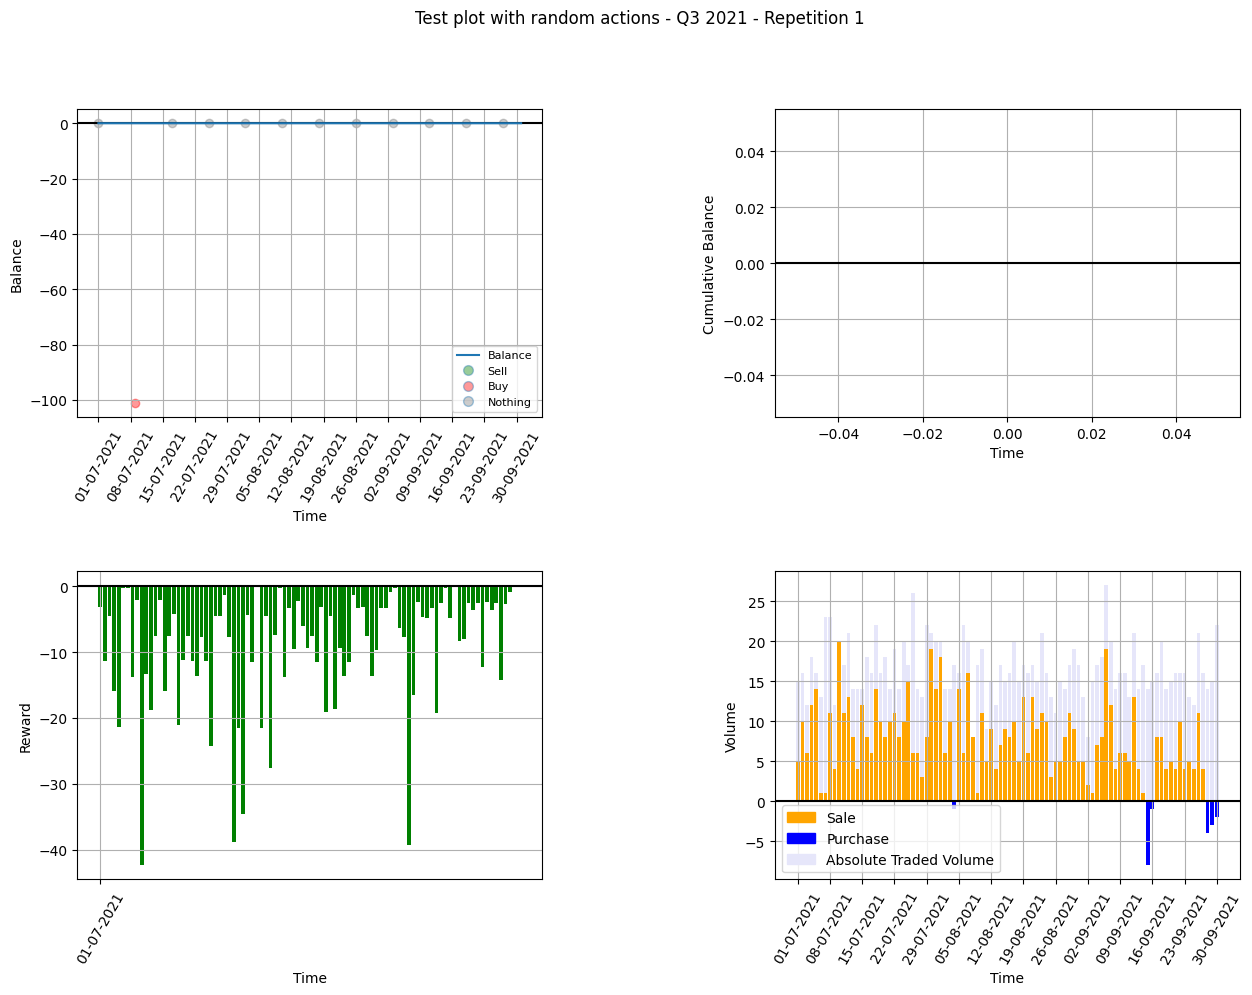


--- Plotting from index 4416 to 8831 - Q4 - Repetition:1 ---



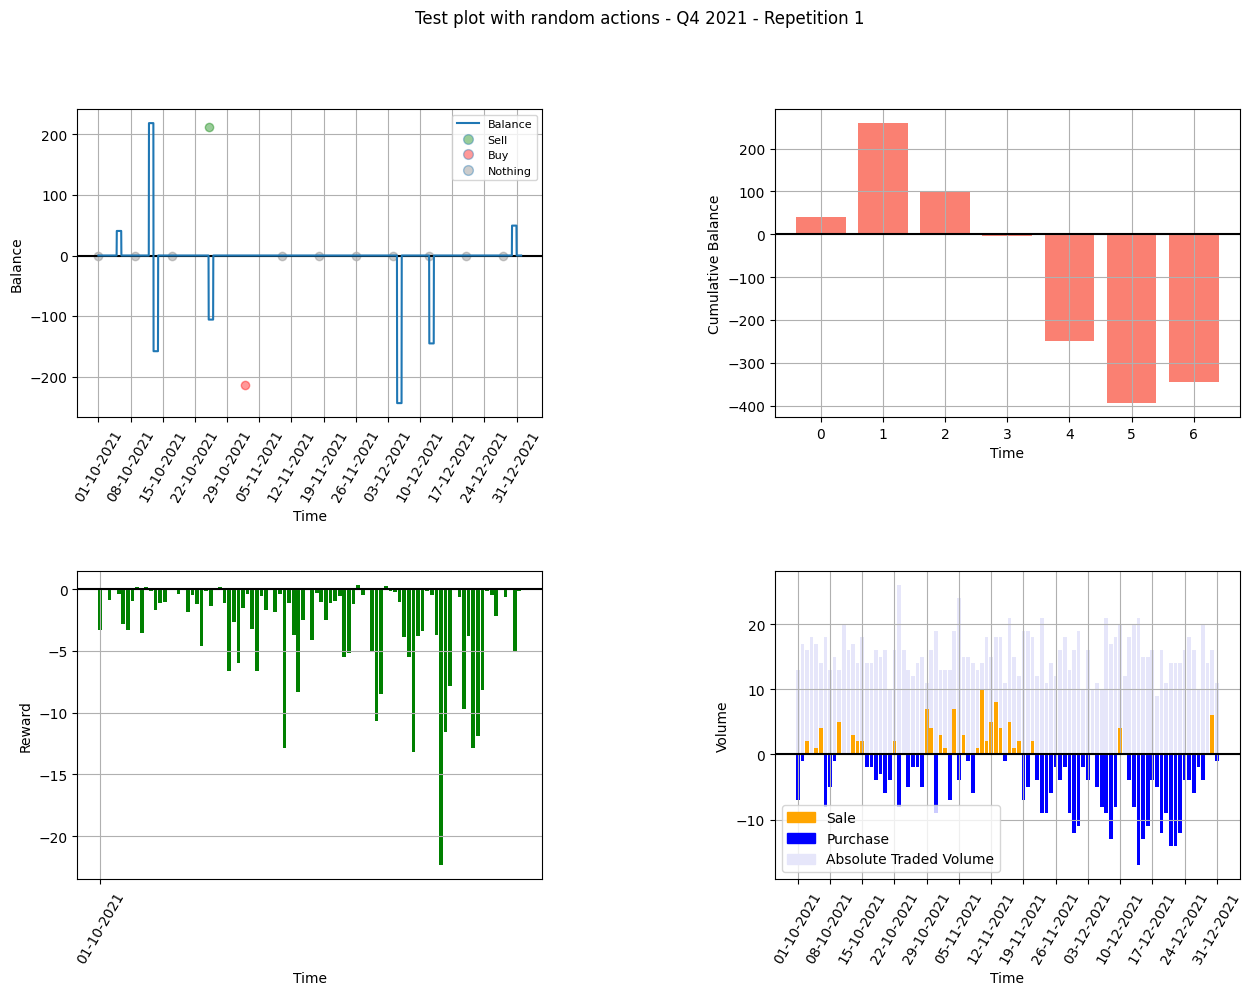


--- Plotting from index 8832 to 13247 - Q3 - Repetition:2 ---



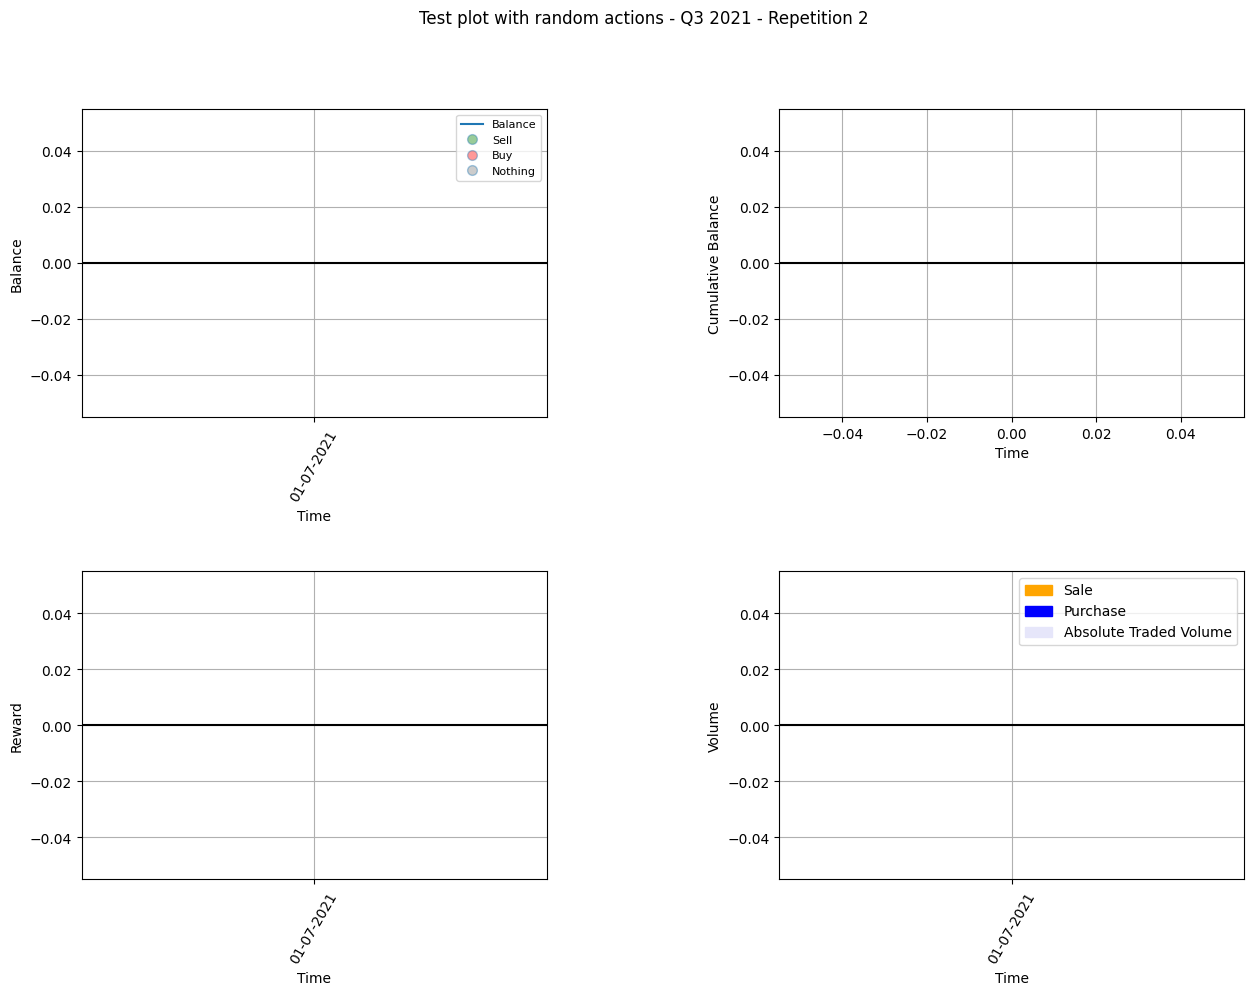

In [ ]:
data = historical_data.copy()

data_column = data['Transaction_Price'].values.reshape(-1,1)

env_stats = TradingStats()

day = 0
env = TradingEnv(data, env_stats, mid_prices_20_22_test, "Test_Environment_")

def random_action():
  a_type = random.randint(-1,1)
  a_price = random.uniform(0.02, 0.5)
  # a_price = a_price / 200
  return (a_type, a_price)

day = 0
retrain_period = 30
for i in range(184):
  # get data for the specific episode
  prices = gbm_run(i+1, 4, 5, historical=False, plot=False, train=False)
  volatility = volatility_as_float(volatilities_20_22_test[i])
  state = env.reset(day, len(prices))

  if i % retrain_period == 0:
    # one month of data added --> retrain XGB
    X = data.drop(["Transaction_Price", "Execution_Time", 'Volume Weighted Price', 'Forecast'], axis=1)
    y = data.Transaction_Price
    y = y.shift(-1)
    drop_index = y[y.isna()].index.tolist()
    X.drop(drop_index, inplace=True)
    y.drop(drop_index, inplace=True)
    xgb_model.fit(X, y)

    data_column = data['Transaction_Price'].values.reshape(-1,1)

  for j in range(len(prices)):
    #state = state.astype(np.float32)
    action = random_action()
    #print(action)
    new_state, reward, done, truncated, info = env.step(action, prices, volatility, xgb_model, day)
    #env_stats.update_gym_log(state, action, reward, new_state)
    state = new_state

  day += 1

info = []
info.append(f"fee = {env.cost_fee}")
env.stats.compute_final_trading_df()
env.render(info, sample_interval=384, train=False, algo="random actions")
env.export_results({"test": "this is a test"}, open_to_drive=True)

Now we train a model from stablebaseline

In [ ]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback

Evaluate the agent each 100 episodes -> 48 * 100 = 4800 (timesteps)
Stop the trining when no update after 5 evaluations

In [ ]:
def train_model(algorithm, timesteps, args, callback=None):

  name = algorithm.__name__
  data = historical_data.copy()
  env_stats = TradingStats()

  day = 0
  env = TradingEnv(data, env_stats, mid_prices_20_22_train, f"{name}_TRAINING")
  env = TradingEnvWrapper(env, day, 48, volatilities_20_22_train, xgb_model, data)
  # stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=5, min_evals=30, verbose = 1)
  # eval_callback = EvalCallback(env, best_model_save_path=f'{env.path}/checkpoints/model',
                               # log_path=f'{env.path}/checkpoints/logs', eval_freq=240, # evaluation every 5 episodes
                               # callback_after_eval=stop_train_callback,
                               # deterministic=True, render=False, verbose=1)

  model = algorithm("MlpPolicy", env, verbose=1, **args)
  rome_tz = pytz.timezone('Europe/Rome')
  start_time = datetime.now(rome_tz)
  start_time_str = start_time.strftime('%Y-%m-%d %H:%M')
  print(f"\n\n---TRAINING START TIME: {start_time_str}---\n\n")

  # model.learn(total_timesteps=timesteps, callback=[eval_callback, checkpoint_callback], progress_bar = True)
  # model.learn(total_timesteps=timesteps, callback=eval_callback, progress_bar = False)
  model.learn(total_timesteps=timesteps, callback=callback, progress_bar = True)

  finish_time = datetime.now(rome_tz)
  finish_time_str = finish_time.strftime('%Y-%m-%d %H:%M')
  time_diff = finish_time - start_time

  seconds = int(time_diff.total_seconds())
  hours, remainder = divmod(seconds, 3600)
  minutes, seconds = divmod(remainder, 60)
  time_diff_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
  print(f"\nTraining took {time_diff_str}\n")
  print(f"\n\n---TRAINING FINISH TIME: {finish_time_str}---\n\n")

  model.save(name+"_"+"trading")
  del model
  model = algorithm.load(name+"_"+"trading", env=env)

  # 547 episodes -> 26256 steps -> 26256 / x = 40 -> x = 26256 / 40 = 656

  env.stats.compute_final_trading_df()
  env.render(mode='human', sample_interval=384, train=True, algo=name)

  rewards = env.stats.trading_df.loc[47::48, 'Cumulative Reward']
  mean_reward = rewards.mean()

  filtered_df = env.stats.trading_df.iloc[47::48]
  num_zero_volume_traded = (filtered_df['Volume Traded'] == 0).sum()
  percentage_unbalancing = num_zero_volume_traded / len(filtered_df) * 100

  final_balance = env.stats.trading_df.iloc[-1]['Cumulative Balance']

  print(f"The mean reward for this quarter was = {mean_reward}")
  print(f'The percentage of balanced episodes is = {percentage_unbalancing}')
  print(f'The final balance is = {final_balance}')

  env.export_results(args, open_to_drive=True)

  return model, data, mean_reward, percentage_unbalancing, final_balance

In [ ]:
def run_gym(episodes, model, data, sample_interval):
  algo_name = str(model).split("_")[1]
  data_column = data['Transaction_Price'].values.reshape(-1,1)

  env_stats_trained = TradingStats()

  day = 0
  env_trained = TradingEnv(data, env_stats_trained, mid_prices_20_22_test)

  retrain_period = 30
  print("---START PROCESSING FROM 1/7/2021---")
  for i in range(episodes):
    print(f"Episode {i+1} of {episodes}")
    prices = gbm_run(i+1, 4, 5, historical=False, plot=False, train=False)
    volatility = volatility_as_float(volatilities_20_22_test[i])
    state = env_trained.reset(day, len(prices))

    if i % retrain_period == 0:
      X = data.drop(["Transaction_Price", "Execution_Time", 'Volume Weighted Price', 'Forecast'], axis=1)
      y = data.Transaction_Price
      y = y.shift(-1)
      drop_index = y[y.isna()].index.tolist()
      X.drop(drop_index, inplace=True)
      y.drop(drop_index, inplace=True)
      xgb_model.fit(X, y)
      data_column = data['Transaction_Price'].values.reshape(-1,1)

    for j in range(len(prices)):
      state = state.astype(np.float32)
      action, _states = model.predict(state, deterministic=True)
      new_state, reward, done, info = env_trained.step(action, prices, volatility, xgb_model)
      # env_stats_trained.update_gym_log(state, action, reward, new_state)
      state = new_state

    day += 1

  info = []
  info.append(f"fee = {env_trained.cost_fee}")
  env_trained.stats.compute_final_trading_df()
  env_trained.render(info, sample_interval=sample_interval, algo=algo_name)
  env_trained.export_results(open=True)
  return env_trained

In [ ]:
quarter_train = 90 * 48
double_quarter_train = (90 + 91) * 48
total_train = len(dates_20_22_train) * 48

In [ ]:
quarter_train, double_quarter_train, total_train

(4320, 8688, 26256)

Log info!!!

The first log shows the mean episode reward (ep_rew_mean) during training, while the second log shows the mean reward (mean_reward) during evaluation. The difference between these two values is that the first one is calculated based on the rewards obtained by the agent during training, while the second one is calculated based on the rewards obtained by the agent during evaluation.

During training, the agent interacts with the environment and updates its policy to maximize its expected cumulative reward. The ep_rew_mean value shown in the first log reflects how well the agent is doing at this task. During evaluation, on the other hand, the agent’s policy is not updated and its performance is measured based on how well it can perform in the environment using its current policy. The mean_reward value shown in the second log reflects how well the agent is doing at this task.

It’s normal for these two values to be different because they reflect different aspects of the agent’s performance. The ep_rew_mean value reflects how well the agent is learning to perform in the environment during training, while the mean_reward value reflects how well the agent can perform in the environment using its current policy during evaluation.

The evaluation frequency can be controlled with the eval_freq parameter. The mean reward is calculated by running the agent on the test environment for a specified number of episodes and averaging the total rewards obtained in each episode.


---


The ep_rew_mean value that is logged during training with the PPO algorithm in Stable Baselines3 represents the mean episodic training reward. It is calculated by averaging the total rewards obtained in each episode over a specified number of episodes. By default, this value is averaged over the last 100 episodes.

The ep_rew_mean value that is logged during training with the PPO algorithm in Stable Baselines3 represents the mean episodic training reward. It is calculated by averaging the total rewards obtained in each episode over a specified number of episodes. By default, this value is averaged over the last 100 episodes.


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
from torch import nn as nn
import optuna
import requests
import glob
import os.path
import traceback


rome_tz = pytz.timezone('Europe/Rome')

def send_telegram_message(text):
    url = f'https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage'
    data = {'chat_id': TELEGRAM_CHAT_ID, 'text': text}
    requests.post(url, data=data)

def send_telegram_plots(image_path):
    url = f'https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto'
    files = {'photo': open(image_path, 'rb')}
    data = {'chat_id': TELEGRAM_CHAT_ID}
    requests.post(url, files=files, data=data)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4,799/4,320  [ 0:03:49 < 0:00:00 , 17 it/s ]


Training took 00:04:18



---TRAINING FINISH TIME: 2023-06-15 15:37---


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

--- Plotting from index 0 to 4367 - Q1 - Repetition:1 ---



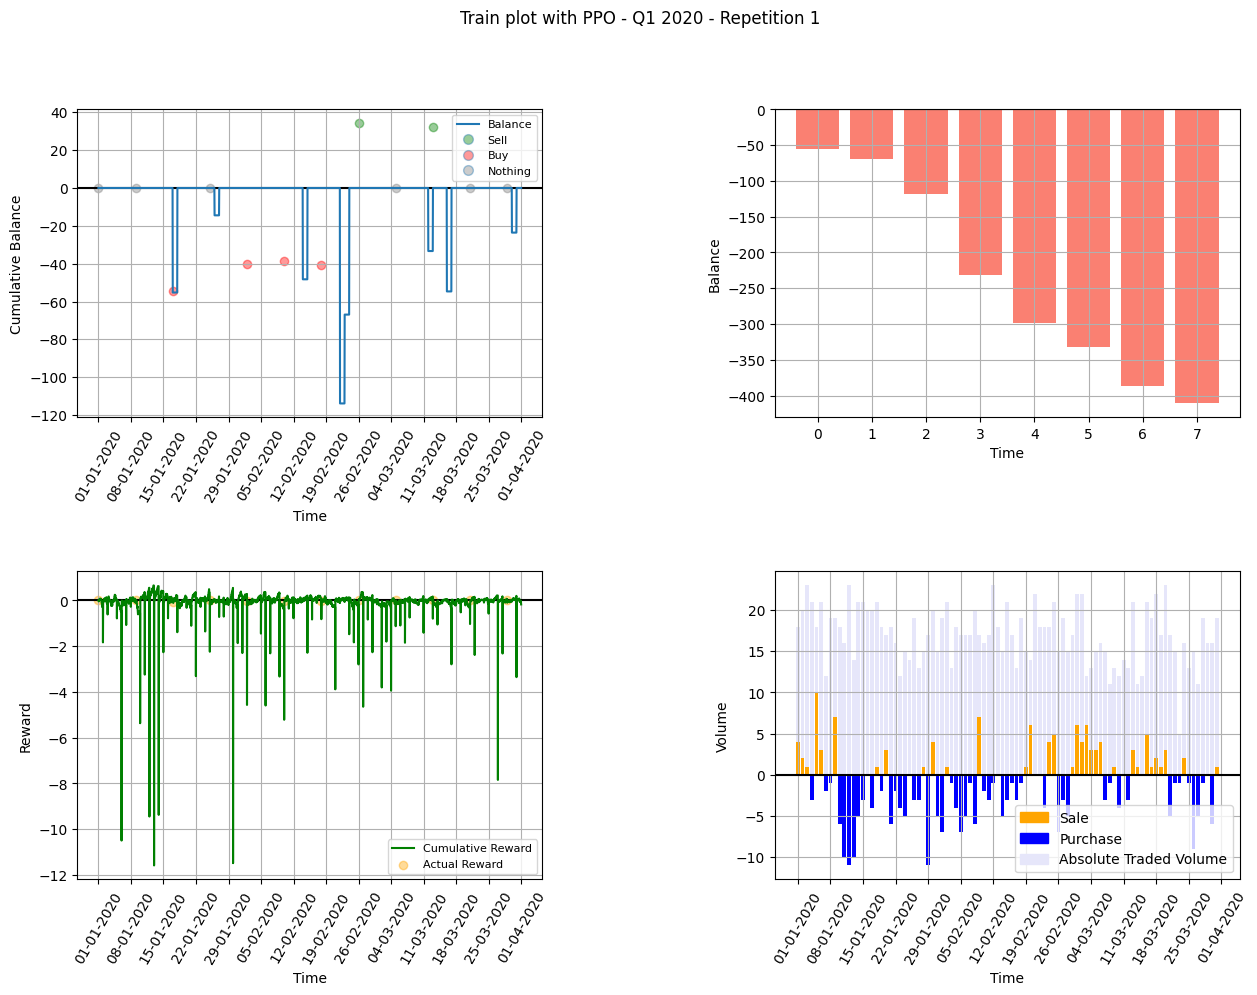


--- Plotting from index 4368 to 8735 - Q2 - Repetition:1 ---



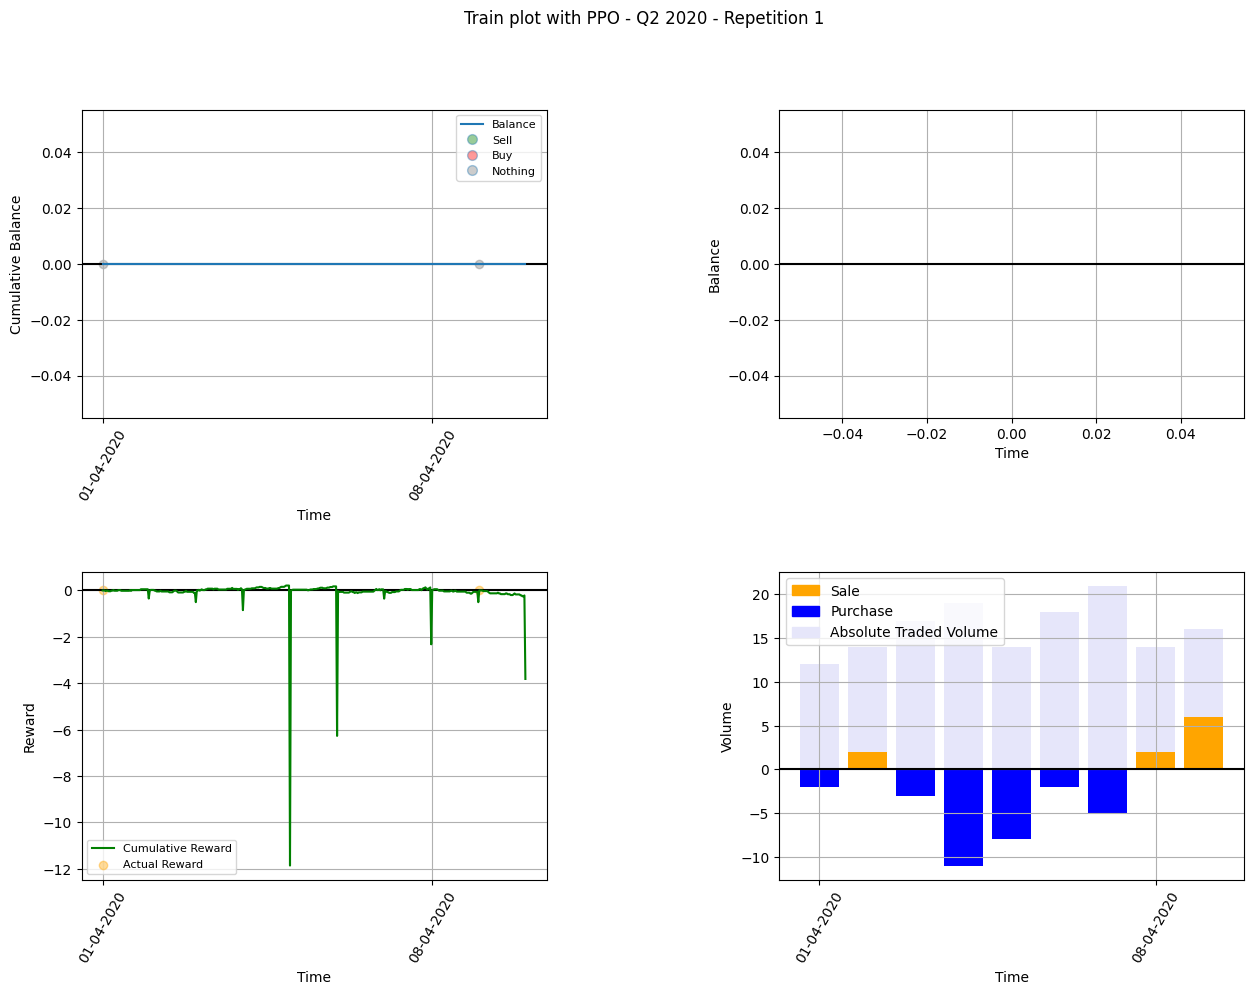

The mean reward for this quarter was = -1.9712980000000002
The percentage of balanced episodes is = 8.0
The final balance is = -410.17


In [ ]:
def optuna_callback(study, trial, n_trials):
    progress = round(len(study.trials) / n_trials * 100, 2)
    best_trial = study.best_trial
    best_params = best_trial.params
    best_params_str = ', '.join([f'{k}: {v}' for k, v in best_params.items()])
    current_trial_duration = trial.duration.total_seconds()
    mean_trial_duration = sum([t.duration.total_seconds() for t in study.trials]) / len(study.trials)
    executor = '🐌 Google Colab'
    if trial.number == best_trial.number:
        message = f'{executor}\nNew best hyperparameters! 🤩\nProgress: {progress}%\nCurrent trial: {trial.number}\nBest trial: {best_trial.number} with value: {best_trial.value:.3f}\nBest hyperparameters: {best_params_str}\nCurrent trial duration: {current_trial_duration:.1f}s\nMean trial duration: {mean_trial_duration:.1f}s'
        folder_path = os.getcwd() + '/'
        file_type = r'PPO_TRAINING_RESULTS_*'
        folders = glob.glob(folder_path + file_type)
        # print(folder_path)
        latest_folder = max(folders, key=os.path.getctime)
        plots_folder_path = latest_folder + '/Plots/'
        # print(plots_folder_path)
        plots_file_type = r'*.png'
        plots_files = glob.glob(plots_folder_path + plots_file_type)
        send_telegram_message(message)
        for plot_file in plots_files:
            send_telegram_plots(plot_file)
    else:
        message = f'{executor}\nNo new better hyperparameters were found 😴\nProgress: {progress}%\nCurrent trial: {trial.number}\nBest trial: {best_trial.number}\nCurrent trial duration: {current_trial_duration:.1f}s\nMean trial duration: {mean_trial_duration:.1f}s'
        send_telegram_message(message)

def objective(trial, df):
  n_steps = trial.suggest_categorical('n_steps', [48, 240, 480, 960, 1440])
  batch_size = trial.suggest_categorical('batch_size', [48, 240, 480, 960, 1440])
  gamma = trial.suggest_categorical('gamma', [0.9, 0.95, 0.99, 0.995, 0.999])
  learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.0002, 0.0003])
  ent_coef = trial.suggest_categorical("ent_coef", [0.00001, 0.0001, 0.001, 0.01, 0.1])
  clip_range = trial.suggest_categorical("clip_range", [0.2, 0.3, 0.4])
  vf_coef = trial.suggest_categorical("vf_coef", [0, 0.5, 1])
  activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
  net_arch = trial.suggest_categorical("net_arch", ["custom", "medium"])
  net_arch = {
      'custom': dict(pi=[64,64,32], vf=[64,64,32]),
      'medium': dict(pi=[256, 256], vf=[256, 256]),
  }[net_arch]
  activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

  hyperparams = {
      'n_steps': n_steps, # the number of steps to run for each environment per update
      'batch_size': batch_size, # Minibatch size
      'gamma': gamma, # Discount factor
      'learning_rate': learning_rate, # The learning rate, it can be a function of the current progress remaining (from 1 to 0)
      'ent_coef': ent_coef, # Entropy coefficient for the loss calculation
      'clip_range': clip_range, # Clipping parameter, it can be a function of the current progress remaining (from 1 to 0).
      'vf_coef': vf_coef, # Value function coefficient for the loss calculation
      'stats_window_size': 1, # Window size for the rollout logging, specifying the number of episodes to average the reported success rate, mean episode length, and mean reward over
      'policy_kwargs' : dict(
          net_arch=net_arch,
          activation_fn=activation_fn
      ),
                 }
  model_PPO, data_PPO, mean_rew, perc_unb, final_bal = train_model(PPO, quarter_train, hyperparams)
  df.loc[len(df)] = {'Trial': len(df) + 1,
                     'Mean Reward': mean_rew,
                     'Balancing Percentage': round(perc_unb,2),
                     'Final Balance': final_bal}
  df.to_excel('Tuning Hyperparameters Stats.xlsx')
  return -mean_rew

# Send a message when the optimization process starts
send_telegram_message(f'🐌 Google Colab\nPPO Hyperparameters Optimization started at {datetime.now(rome_tz)} with: {double_quarter_train} train timesteps.')

study = optuna.create_study(storage='sqlite:///train_env.db') # create db for checkpoints
n_trials = 100
try:
  tuning_df = pd.DataFrame(data=[], columns=['Trial','Mean Reward', 'Balancing Percentage', 'Final Balance'])
  study.optimize(lambda trial: objective(trial, tuning_df), n_trials=n_trials, callbacks=[lambda study, trial: optuna_callback(study, trial, n_trials)])
  # Send a message when the optimization process is complete
  send_telegram_message(f'🐌 Google Colab\nOptimization completed at {datetime.now(rome_tz)}')
  print(f'These are the best hypeparameter:\n{study.best_params}\n')
except Exception as e:
  error_message = f'🐌 ⚠️ Google Colab\nError occurred during optimization: {str(e)}\n{traceback.format_exc()}'
  send_telegram_message(error_message)

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---TRAINING START TIME: 2023-06-13 09:37---




Day:30 - Fitting again the XGB model.

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -1.73    |
| time/              |          |
|    fps             | 37       |
|    iterations      | 1        |
|    time_elapsed    | 68       |
|    total_timesteps | 2544     |
---------------------------------


Day:60 - Fitting again the XGB model.

Day:90 - Fitting again the XGB model.

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | -1.51         |
| time/                   |               |
|    fps                  | 32            |
|    iterations           | 2             |
|    time_elapsed         | 157           |
|    total_timesteps      | 5088          |
| train/                  |               |
|    approx_kl            | 0.00027945873 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -2.84         |
|    explained_variance   | -0.426        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.225         |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000753     |
|    std                  | 1             |
|    value_loss           | 0.285         |
-------------------------------------------


Day:120 - Fitting again the XGB model.

Day:150 - Fitting again the XGB model.

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | -1.7          |
| time/                   |               |
|    fps                  | 28            |
|    iterations           | 3             |
|    time_elapsed         | 264           |
|    total_timesteps      | 7632          |
| train/                  |               |
|    approx_kl            | 0.00030987925 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -2.84         |
|    explained_variance   | -0.625        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.1           |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.000472     |
|    std                  | 0.999         |
|    value_loss           | 0.116         |
-------------------------------------------


Day:180 - Fitting again the XGB model.

Day:210 - Fitting again the XGB model.

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 48            |
|    ep_rew_mean          | -2.06         |
| time/                   |               |
|    fps                  | 26            |
|    iterations           | 4             |
|    time_elapsed         | 390           |
|    total_timesteps      | 10176         |
| train/                  |               |
|    approx_kl            | 0.00026507262 |
|    clip_fraction        | 0             |
|    clip_range           | 0.4           |
|    entropy_loss         | -2.84         |
|    explained_variance   | -0.105        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.327         |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.000209     |
|    std                  | 0.998         |
|    value_loss           | 0.346         |
-------------------------------------------



Training took 00:06:30



---TRAINING FINISH TIME: 2023-06-13 09:44---


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

--- Plotting from index 0 to 4367 - Q1 - Repetition:1 ---



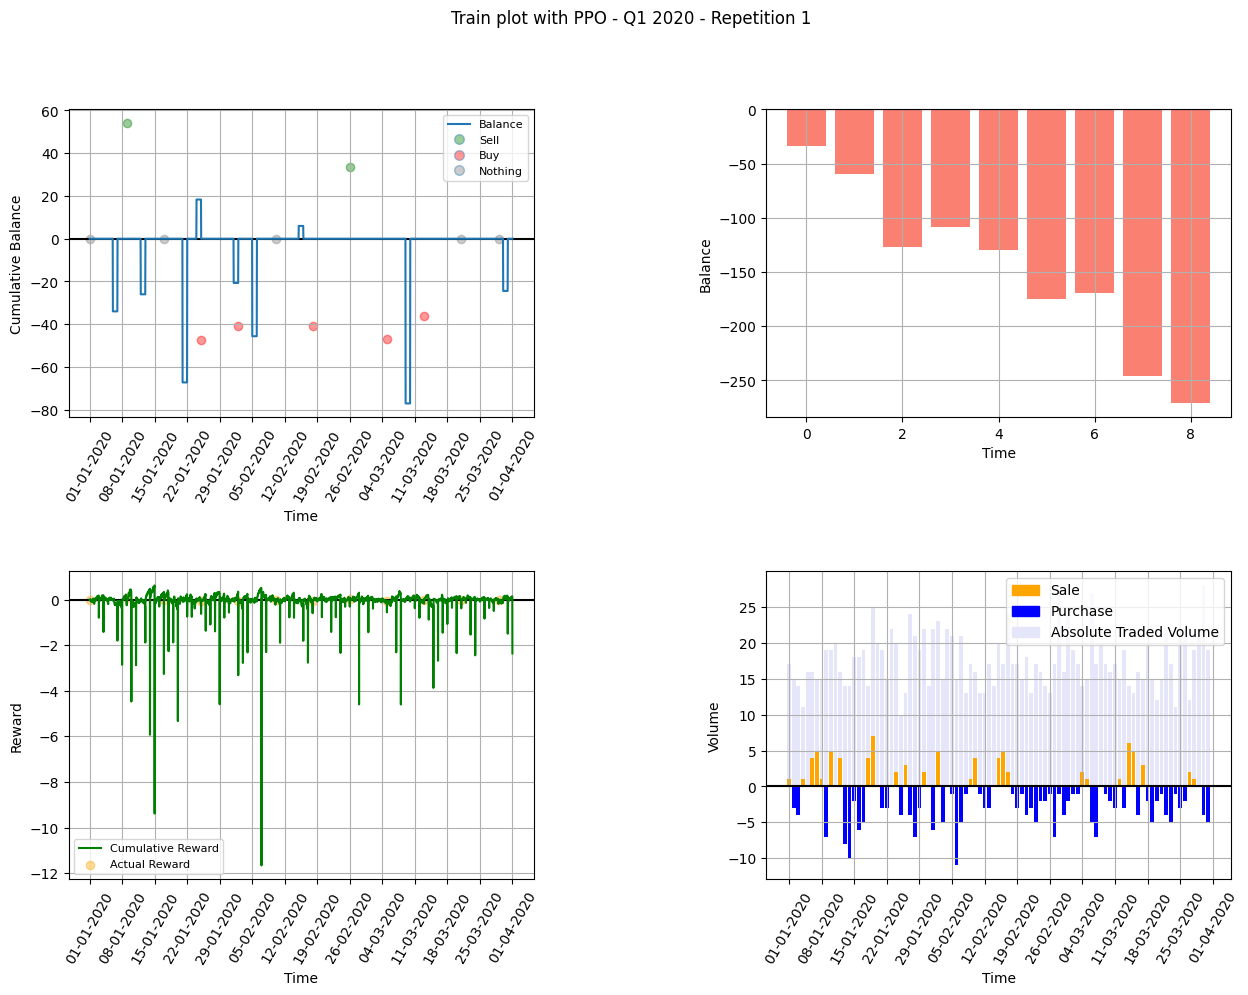


--- Plotting from index 4368 to 8735 - Q2 - Repetition:1 ---



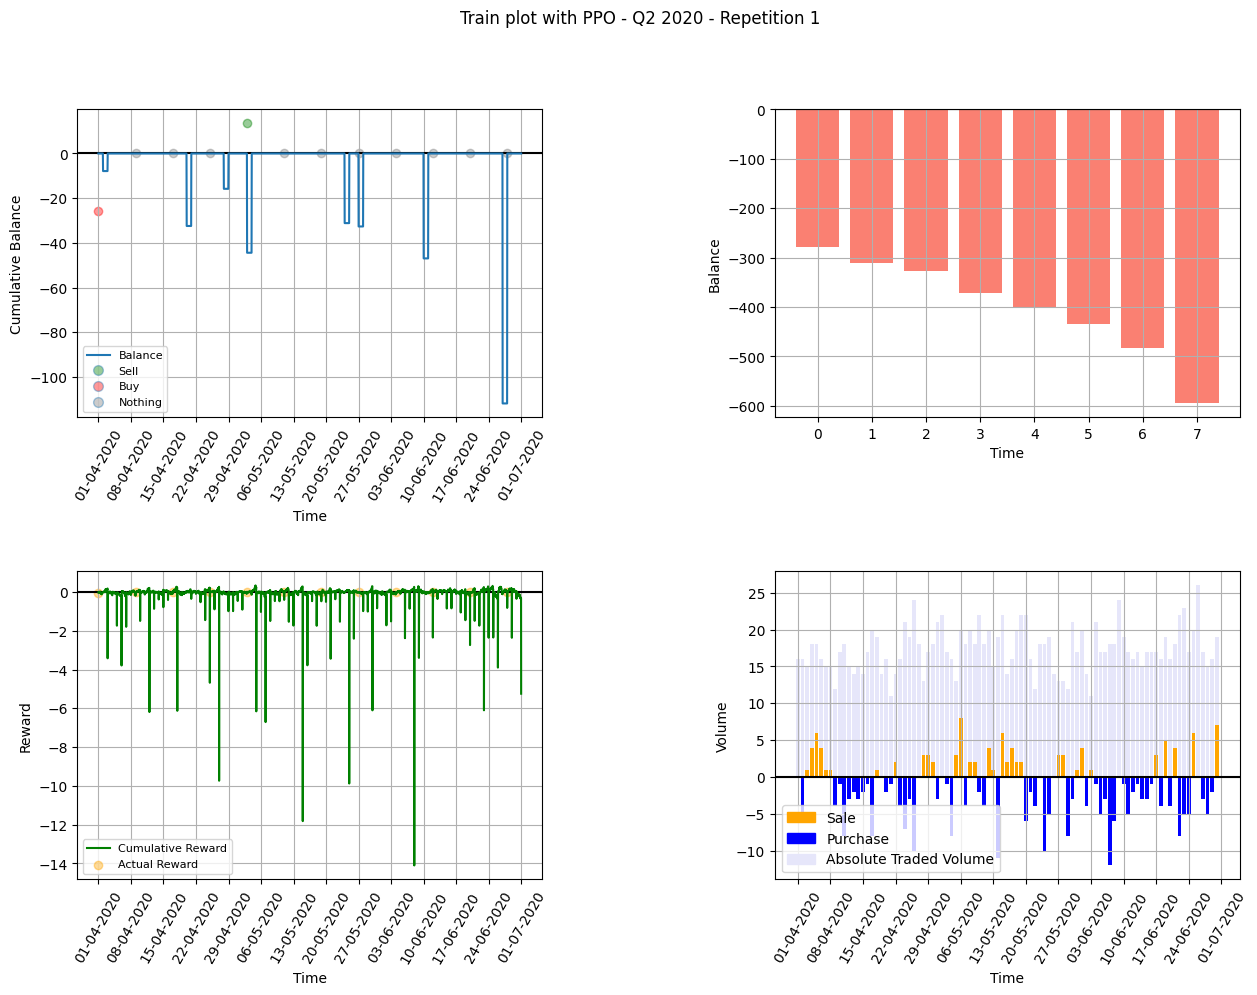


--- Plotting from index 8736 to 13151 - Q3 - Repetition:1 ---



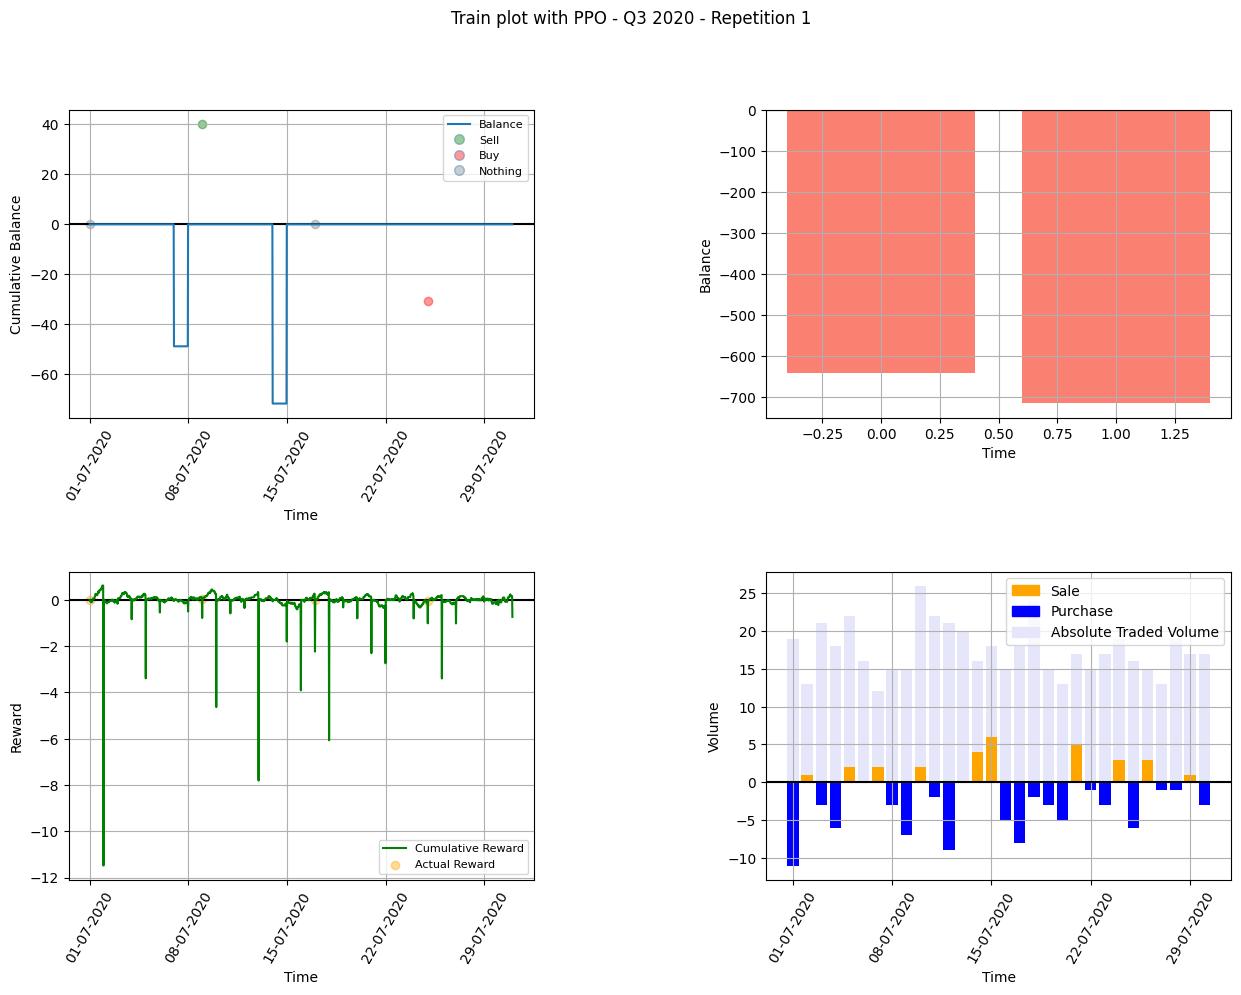

The mean reward for this quarter was = -1.7385615094339626
The percentage of balanced episodes is = 8.962264150943396
The final balance is = -714.15


In [ ]:
training_hyperparams = {
    'policy_kwargs': {
        'activation_fn':nn.Tanh,
        'net_arch':dict(pi=[64,64,32], vf=[64,64,32]),
    },
    'learning_rate': 0.0001,
    'n_steps': 2544,
    'batch_size': 2544,
    'gamma': 0,
    'clip_range': 0.4,
    'ent_coef': 0.001,
    'vf_coef': 0.984
}

try:
  send_telegram_message(f'🐌 Google Colab\nStart training with tuned hyperparameters ({training_hyperparams}) at {datetime.now(rome_tz)} with negative fee = 0.2!☑️')
  model_PPO_train, data_PPO_train, mean_rew_train, _, _ = train_model(PPO, double_quarter_train, training_hyperparams)
  send_telegram_message("🐌 Google Colab\nThe following are the train plots 📈")
  folder_path = os.getcwd() + '/'
  file_type = r'PPO_TRAINING_RESULTS_*'
  folders = glob.glob(folder_path + file_type)
  latest_folder = max(folders, key=os.path.getctime)
  plots_folder_path = latest_folder + '/Plots/'
  plots_file_type = r'*.png'
  plots_files = glob.glob(plots_folder_path + plots_file_type)
  for plot_file in plots_files:
    send_telegram_plots(plot_file)
  send_telegram_message(f'The mean reward is {mean_rew_train}')
  send_telegram_message(f'Training ended at {datetime.now(rome_tz)}!⛔')
except Exception as e:
  send_telegram_message(f'🐌 Google Colab\nAn error/exception occurred during training: {str(e)}\n{traceback.format_exc()}')

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---TRAINING START TIME: 2023-06-12 16:28---




Day:30 - Fitting again the XGB model.

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | -1.9     |
| time/              |          |
|    fps             | 20       |
|    iterations      | 1        |
|    time_elapsed    | 99       |
|    total_timesteps | 2048     |
---------------------------------


Day:60 - Fitting again the XGB model.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -2.25        |
| time/                   |              |
|    fps                  | 18           |
|    iterations           | 2            |
|    time_elapsed         | 223          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0051287916 |
|    clip_fraction        | 0.0508       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.0294      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.57         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.004       |
|    std                  | 1.01         |
|    value_loss           | 1.07         |
------------------------------------------


Day:90 - Fitting again the XGB model.

Day:120 - Fitting again the XGB model.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -2.05        |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 3            |
|    time_elapsed         | 371          |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0081580235 |
|    clip_fraction        | 0.0767       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.21         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.465        |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.0102      |
|    std                  | 1.01         |
|    value_loss           | 1.1          |
------------------------------------------


Day:150 - Fitting again the XGB model.

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 48          |
|    ep_rew_mean          | -1.62       |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 4           |
|    time_elapsed         | 535         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007809243 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.109       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00729    |
|    std                  | 1.01        |
|    value_loss           | 0.445       |
-----------------------------------------


Day:180 - Fitting again the XGB model.

Day:210 - Fitting again the XGB model.

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 48           |
|    ep_rew_mean          | -1.38        |
| time/                   |              |
|    fps                  | 14           |
|    iterations           | 5            |
|    time_elapsed         | 726          |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0077054077 |
|    clip_fraction        | 0.065        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.278        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0977       |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.0118      |
|    std                  | 1.01         |
|    value_loss           | 0.452        |
------------------------------------------



Training took 00:12:08



---TRAINING FINISH TIME: 2023-06-12 16:40---


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

--- Plotting from index 0 to 4367 - Q1 - Repetition:1 ---



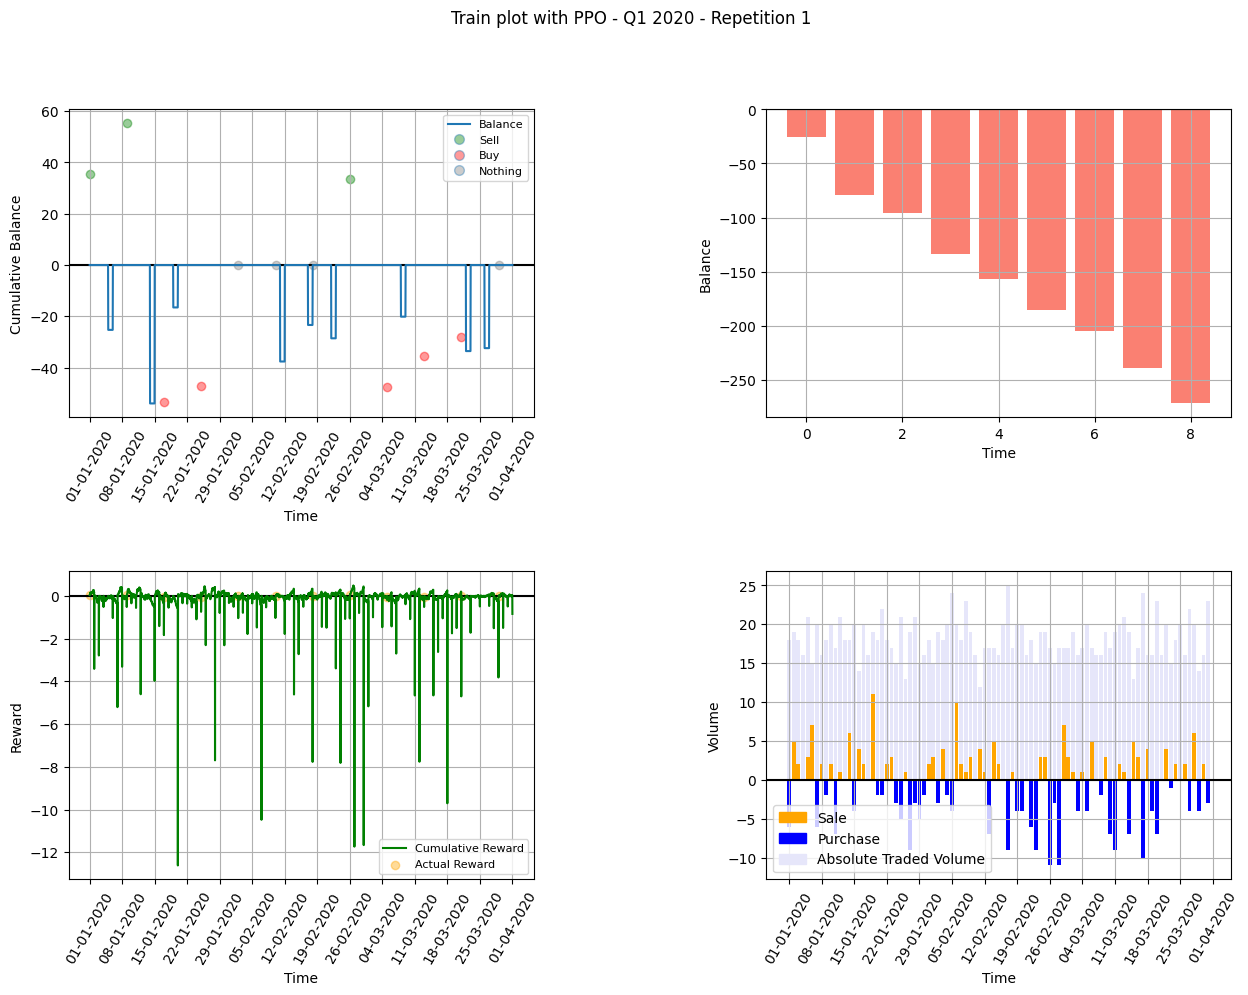


--- Plotting from index 4368 to 8735 - Q2 - Repetition:1 ---



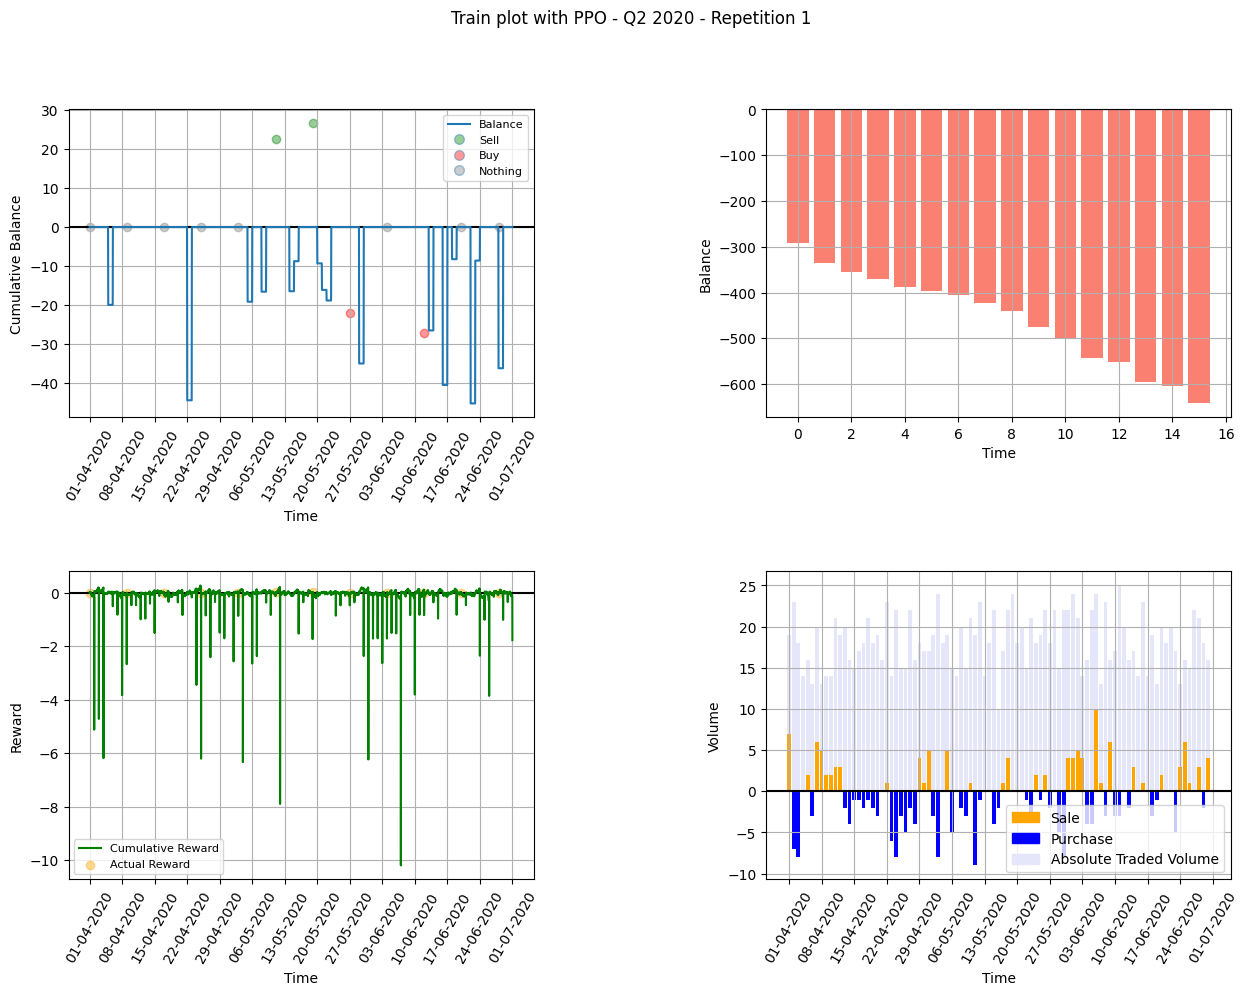


--- Plotting from index 8736 to 13151 - Q3 - Repetition:1 ---



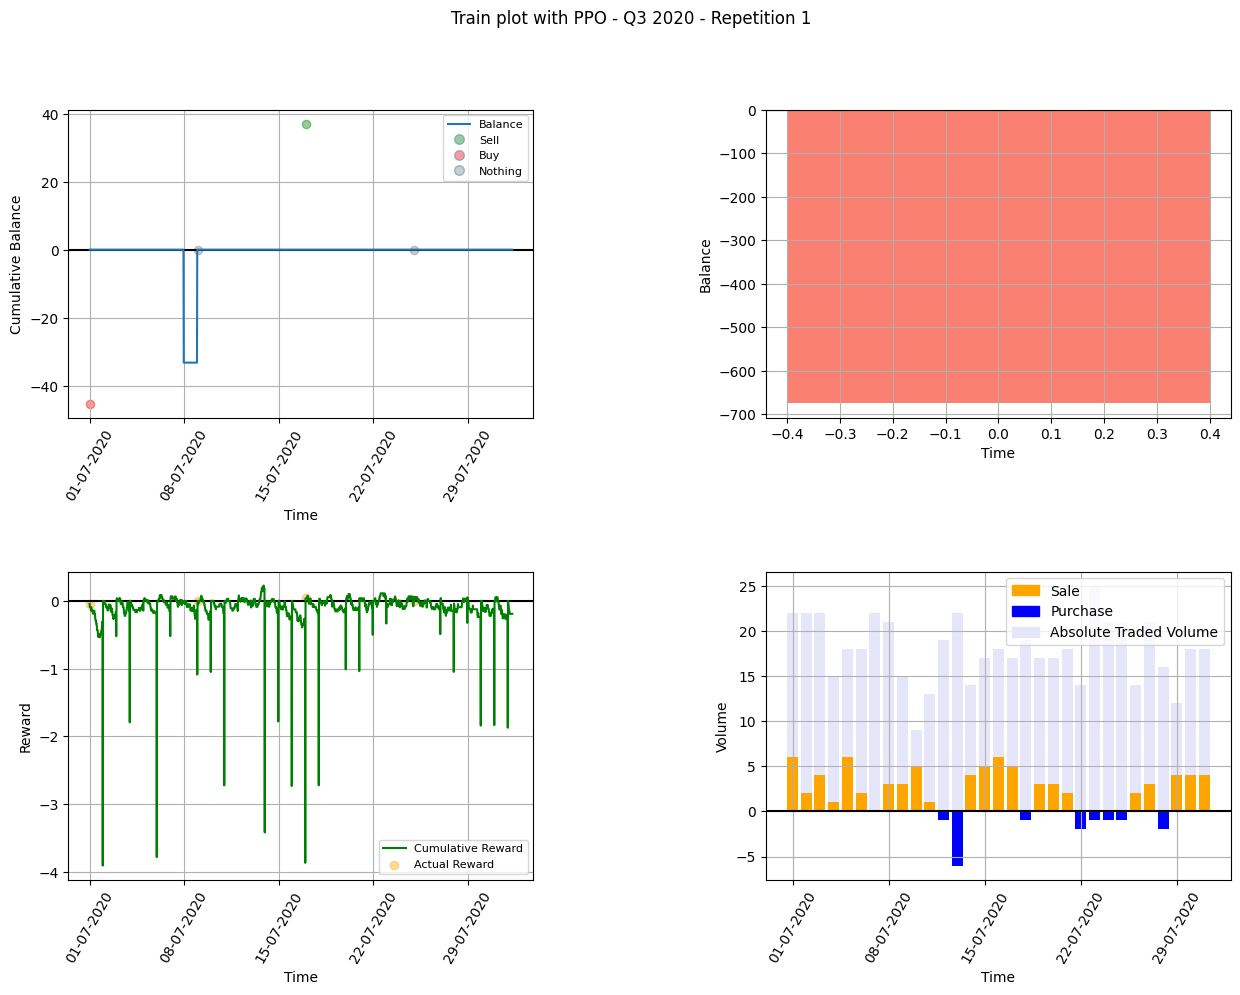

The mean reward for this quarter was = -1.7307545539906102
The percentage of balanced episodes is = 12.206572769953052
The final balance is = 0.0


In [ ]:
training_hyperparams = {}

try:
  send_telegram_message(f'🐌 Google Colab\nStart training with tuned hyperparameters ({training_hyperparams}) at {datetime.now(rome_tz)} with negative fee = 0.2!☑️')
  model_PPO_train, data_PPO_train, mean_rew_train, _, _ = train_model(PPO, double_quarter_train, training_hyperparams)
  send_telegram_message("🐌 Google Colab\nThe following are the train plots 📈")
  folder_path = os.getcwd() + '/'
  file_type = r'PPO_TRAINING_RESULTS_*'
  folders = glob.glob(folder_path + file_type)
  latest_folder = max(folders, key=os.path.getctime)
  plots_folder_path = latest_folder + '/Plots/'
  plots_file_type = r'*.png'
  plots_files = glob.glob(plots_folder_path + plots_file_type)
  for plot_file in plots_files:
    send_telegram_plots(plot_file)
  send_telegram_message(f'The mean reward is {mean_rew_train}')
  send_telegram_message(f'Training ended at {datetime.now(rome_tz)}!⛔')
except Exception as e:
  send_telegram_message(f'🐌 Google Colab\nAn error/exception occurred during training: {str(e)}\n{traceback.format_exc()}')

In [ ]:
# uncomment to load from the specific error
study = optuna.load_study(study_name='no-name-9e048c58-b8cd-42dd-8a29-1c9df2b63eca', storage='sqlite:///train_env.db')

In [ ]:
test_episodes = 184

In [ ]:
ppo_env = run_gym(test_episodes, model_PPO, data_PPO, 96)

In [ ]:
warnings.filterwarnings('default')